# Practical Assignment 3 - Clustering

### Image Adhikari
#### Computer Engineering
#### Roll No.: 02

In this assignment, we try to find related posts and measure the relatedness of the posts. Here, we work with unlabelled data. We find some pattern within the data itself. The naive approach would be to simply take the post, calculate its similarity to all other posts, and display the top n most similar posts as links on the page. This would quickly become very costly. Instead, we need a method that quickly finds all the related posts.

We will achieve this goal in this chapter by clustering features we have extracted from text. Clustering is a method of arranging items so that similar items are in one cluster and dissimilar items are in distinct ones.

#### Importing the required utilities

In [1]:
import os
from pathlib import Path

import numpy as np
import scipy

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

DPI = 300

#### Paths to access data from and save plots to

In [3]:
# Setting the path to access the .csv file
DATA_DIR = Path("data")
if not DATA_DIR.exists():
    raise Exception("Data directory %s not found" % CHART_DIR.absolute())
    
# Creating the folder to save the plots     
CHART_DIR = Path("charts")
if not CHART_DIR.exists():
    CHART_DIR.mkdir()

#### Defining function to save the plots

In [4]:
def save_png(name):
    fn = 'B09124_06_%s.png'%name
    plt.savefig(str(CHART_DIR / fn), bbox_inches="tight")

## Converting raw text into a bag of words

The __bag-of-words model__ is a simplifying representation used in natural language processing and information retrieval. It is a robust approach to measuring text similarity compared to edit distance or Levenshtein distance. It ignores the order of words and simply uses word counts as their basis. For each word in the post, its occurrence is counted and noted in a vector. Not surprisingly, this step is also called __vectorization__. The vector is typically huge as it contains as many elements as words that occur in the whole dataset.

We do not have to write custom code for counting words and representing those counts as a vector. Scikit's CountVectorizer method, does the job efficiently but also has a very convenient interface:

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=1)
print(vectorizer)

CountVectorizer()


In [6]:
content = ["How to format my hard disk", 
           " Hard disk format  problems "]

The _fit_transform()_ function of our vectorizer does all the hard vectorization work for us. We can simply put the list of subject lines as the parameter to the function.

In [7]:
X = vectorizer.fit_transform(content)
vectorizer.get_feature_names_out()

array(['disk', 'format', 'hard', 'how', 'my', 'problems', 'to'],
      dtype=object)

In [8]:
print(X.toarray())

[[1 1 1 1 1 0 1]
 [1 1 1 0 0 1 0]]


In [9]:
print(X.toarray().transpose()) 

[[1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]


This means that the first sentence contains all the words except problems, while the second contains all but how, my, and to.

## Counting words

In [10]:
TOY_DIR = DATA_DIR / "toy"
posts = [p.read_text() for p in TOY_DIR.iterdir()]

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=1) 

In [11]:
X_train = vectorizer.fit_transform(posts)
num_samples, num_features = X_train.shape
print("#samples: %d, #features: %d" % (num_samples,  num_features))

#samples: 5, #features: 25


We can see that we have 5 posts with a total of 25 different words. We can see the tokenized words below:

In [12]:
print(vectorizer.get_feature_names_out())

['about' 'actually' 'capabilities' 'contains' 'data' 'databases' 'images'
 'imaging' 'interesting' 'is' 'it' 'learning' 'machine' 'most' 'much'
 'not' 'permanently' 'post' 'provide' 'save' 'storage' 'store' 'stuff'
 'this' 'toy']


In [13]:
new_post = "imaging databases"
new_post_vec = vectorizer.transform([new_post]) 
print(new_post_vec)

  (0, 5)	1
  (0, 7)	1


In [14]:
print(new_post_vec.toarray())

[[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [15]:
def dist_raw(v1, v2): 
    delta = v1-v2
    return scipy.linalg.norm(delta.toarray())

The _norm()_ function calculates the Euclidean norm (shortest distance). This is just one obvious first pick, and there are many more interesting ways to calculate the distance.

With _dist_raw_, we just need to iterate over all the posts and remember the nearest one. We now define a convenience function that takes the current dataset and the new post in vectorized form as well as a distance function and prints out an analysis of how well the distance function works.

In [16]:
def best_post(X, new_vec, dist_func):
    best_doc = None
    best_dist = float('inf')
    best_i = None
    for i, post in enumerate(posts):
        if post == new_post: 
            continue 
        post_vec = X.getrow(i) 
        d = dist_func(post_vec, new_vec) 
        print("=== Post %i with dist=%.2f:\n    '%s'" % \
              (i, d, post)) 
        if d < best_dist: 
            best_dist = d 
            best_i = i
    print("\n==> Best post is %i with dist=%.2f" % \
          (best_i, best_dist))
    
best_post(X_train, new_post_vec, dist_raw)

=== Post 0 with dist=4.00:
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=1.73:
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=2.00:
    'Most imaging databases save images permanently.
'
=== Post 3 with dist=1.41:
    'Imaging databases store data.'
=== Post 4 with dist=5.10:
    'Imaging databases store data. Imaging databases store data. Imaging databases store data.'

==> Best post is 3 with dist=1.41


We have our first similarity measurement. Post 0 is most dissimilar from our new post. Quite understandably, it does not have a single word in common with the new post. We can also understand that Post 1 is very similar to the new post, but not the winner, as it contains one word more than Post 3, which is not contained in the new post.

Looking at Post 3 and Post 4, however, the picture is not so clear. Post 4 is the same as Post 3 duplicated three times. So, it should also be as similar to the new post as Post 3.

In [17]:
print(X_train.getrow(3).toarray())

[[0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]]


In [18]:
print(X_train.getrow(4).toarray())

[[0 0 0 0 3 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0]]


Using only the counts of the raw words is insufficient. We will have to normalize them to get vectors of unit length.

## Normalizing word count vectors

Making sure the function _dist_raw_ calculates the vector distance on the normalized vectors and not on the raw vectors.

In [19]:
def dist_norm(v1, v2): 
    v1_normalized = v1 / scipy.linalg.norm(v1.toarray()) 
    v2_normalized = v2 / scipy.linalg.norm(v2.toarray()) 
    delta = v1_normalized - v2_normalized  
    return scipy.linalg.norm(delta.toarray()) 

In [20]:
best_post(X_train, new_post_vec, dist_norm)

=== Post 0 with dist=1.41:
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86:
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.92:
    'Most imaging databases save images permanently.
'
=== Post 3 with dist=0.77:
    'Imaging databases store data.'
=== Post 4 with dist=0.77:
    'Imaging databases store data. Imaging databases store data. Imaging databases store data.'

==> Best post is 3 with dist=0.77


This looks a bit better now. Post 3 and Post 4 are calculated as being equally similar.

## Removing less important words

Having another look at Post 2, we can see that of its words that are not in the new post, we have most, save, images, and permanently. They are quite different in the overall importance to the post. Words such as most appear very often in all sorts of different contexts and are called __stop words__. They do not carry as much information and thus should not be weighed as high as words such as images, which don't occur often in different contexts. The best option would be to remove all the words that are so frequent that they do not help us to distinguish between different texts. These words are called __stop words__.

As this is such a common step in text processing, there is a simple parameter in CountVectorizer to achieve that:

In [21]:
vect_engl = CountVectorizer(min_df=1, stop_words='english')
print(sorted(vect_engl.get_stop_words())[0:20])

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst']


The new word list is seven words lighter:

In [22]:
X_train_engl = vect_engl.fit_transform(posts)
num_samples_engl, num_features_engl = X_train_engl.shape
print("#samples: %d, #features: %d" % (num_samples_engl,  num_features_engl))
print(vect_engl.get_feature_names_out())

#samples: 5, #features: 18
['actually' 'capabilities' 'contains' 'data' 'databases' 'images'
 'imaging' 'interesting' 'learning' 'machine' 'permanently' 'post'
 'provide' 'save' 'storage' 'store' 'stuff' 'toy']


In [23]:
new_post_vec_engl = vect_engl.transform([new_post]) 
print(new_post_vec_engl)

  (0, 4)	1
  (0, 6)	1


The new similarity measurement after removing the stop words is as follows:

In [24]:
best_post(X_train_engl, new_post_vec_engl, dist_norm)

=== Post 0 with dist=1.41:
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86:
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.86:
    'Most imaging databases save images permanently.
'
=== Post 3 with dist=0.77:
    'Imaging databases store data.'
=== Post 4 with dist=0.77:
    'Imaging databases store data. Imaging databases store data. Imaging databases store data.'

==> Best post is 3 with dist=0.77


## Stemming using NLTK

We need a function that reduces words to their specific word stem. Post 2, for instance, contains imaging and images. It make sense to count them together. After all, it is the same concept they are referring to.

Scikit does not contain a stemmer by default. With the __Natural Language Toolkit (NLTK)__, we can download a free software toolkit, which provides a stemmer that we can easily plug into _CountVectorizer_.

In [25]:
import nltk.stem

In [26]:
s = nltk.stem.SnowballStemmer('english')
print(s.stem("graphics"))
print(s.stem("imaging"))
print(s.stem("image"))
print(s.stem("imagination"))
print(s.stem("imagine"))
print(s.stem("buys"))
print(s.stem("buying"))
print(s.stem("bought"))

graphic
imag
imag
imagin
imagin
buy
buy
bought


We stem the posts before we feed them into CountVectorizer. The class provides several hooks with which we can customize the stage's preprocessing and tokenization. The preprocessor and tokenizer can be set as parameters in the constructor. We do not want to place the stemmer into any of them, because we will then have to do the tokenization and normalization ourselves. Instead, we overwrite the build_analyzer method:

In [27]:
english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer): 
    def build_analyzer(self): 
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in  analyzer(doc))

In [28]:
vect_engl_stem = StemmedCountVectorizer(min_df=1, stop_words='english')        
print(vect_engl_stem)

StemmedCountVectorizer(stop_words='english')


This will do the following process for each post:
1. Lowercase the raw post in the preprocessing step (done in the parent class).
2. Extract all individual words in the tokenization step (done in the parent class).
3. Convert each word into its stemmed version (done in our _build_analyzer_).

As a result, we now have one less feature, because images and imaging collapsed to one:

In [29]:
X_train_engl_stem = vect_engl_stem.fit_transform(posts)
num_samples_engl_stem, num_features_engl_stem = X_train_engl_stem.shape
print("#samples: %d, #features: %d" % (num_samples_engl_stem,  num_features_engl_stem))
print(vect_engl_stem.get_feature_names())

#samples: 5, #features: 17
['actual', 'capabl', 'contain', 'data', 'databas', 'imag', 'interest', 'learn', 'machin', 'perman', 'post', 'provid', 'save', 'storag', 'store', 'stuff', 'toy']


C:\Users\image\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
new_post_vec_engl_stem = vect_engl_stem.transform([new_post]) 
print(new_post_vec_engl_stem)

best_post(X_train_engl_stem, new_post_vec_engl_stem, dist_norm)

  (0, 4)	1
  (0, 5)	1
=== Post 0 with dist=1.41:
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86:
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.63:
    'Most imaging databases save images permanently.
'
=== Post 3 with dist=0.77:
    'Imaging databases store data.'
=== Post 4 with dist=0.77:
    'Imaging databases store data. Imaging databases store data. Imaging databases store data.'

==> Best post is 2 with dist=0.63


We now see that collapsing imaging and images revealed that actually, Post 2 is the most similar post to our new post, as it contains the concept image twice:

## Stop words on steroids using TFIDF

The feature values simply count occurrences of terms in a post. But there will always be the problem that some terms are just more discriminative than others. 

This can only be solved by counting term frequencies for every post and, in addition, discounting those that appear in many posts. In other words, we want a high value for a given term in a given value if that term occurs often in that particular post and very seldom anywhere else.

This is exactly what __term frequency - inverse document frequency (TF-IDF)__ does. TF stands for the counting part, while IDF factors in the discounting.

In [31]:
def tfidf(term, doc, corpus):
    tf = doc.count(term) / len(doc)
    idf = np.log(float(len(corpus)) / (len([d for d in corpus if term in d])))
    tf_idf = tf * idf
    print("term='%s'   doc=%-17s tf=%.2f   idf=%.2f"%\
          (term, doc, tf, idf))
    return tf_idf

We did not simply count the terms, but also normalized the counts by the
document length. This way, longer documents do not have an unfair  advantage over shorter ones. Of course for fast computation, we would move the IDF calculation out of the function, since it is the same value for all documents.

For the following documents, D, consisting of three already tokenized documents, we can see how the terms are treated differently, although all appear equally often per document:

In [32]:
# defining some documents
a, abb, abc = ["a"], ["a", "b", "b"], ["a", "b", "c"]

# defining some copora
D = [a, abb, abc]

print("=> tfidf=%.2f" % tfidf("a", a, D))
print("=> tfidf=%.2f" % tfidf("a", abb, D))
print("=> tfidf=%.2f" % tfidf("a", abc, D))
print("=> tfidf=%.2f" % tfidf("b", abb, D))
print("=> tfidf=%.2f" % tfidf("b", abc, D))
print("=> tfidf=%.2f" % tfidf("c", abc, D))

term='a'   doc=['a']             tf=1.00   idf=0.00
=> tfidf=0.00
term='a'   doc=['a', 'b', 'b']   tf=0.33   idf=0.00
=> tfidf=0.00
term='a'   doc=['a', 'b', 'c']   tf=0.33   idf=0.00
=> tfidf=0.00
term='b'   doc=['a', 'b', 'b']   tf=0.67   idf=0.41
=> tfidf=0.27
term='b'   doc=['a', 'b', 'c']   tf=0.33   idf=0.41
=> tfidf=0.14
term='c'   doc=['a', 'b', 'c']   tf=0.33   idf=1.10
=> tfidf=0.37


We see that a carries no meaning for any document since it is contained everywhere. The b term is more important for the document abb than for abc as it occurs there twice.

In reality, there are more corner cases to handle than in the preceding example. Thanks to scikit, we don't have to think of them as they are already nicely packaged in _TfidfVectorizer_, which inherits from _CountVectorizer_. We don't want to miss our stemmer:

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

class StemmedTfidfVectorizer(TfidfVectorizer):

    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

vect_tfidf = StemmedTfidfVectorizer(#min_df=10, max_df=0.5,
                                    stop_words='english', decode_error='ignore')
print(vect_tfidf)

StemmedTfidfVectorizer(decode_error='ignore', stop_words='english')


The resulting document vectors will not contain counts any more. Instead, they will contain the individual TF-IDF values per term.

In [34]:
X_train_tfidf = vect_tfidf.fit_transform(posts)
num_samples_tfidf, num_features_tfidf = X_train_tfidf.shape
print("#samples: %d, #features: %d" % (num_samples_tfidf,  num_features_tfidf))
print(vect_tfidf.get_feature_names())

#samples: 5, #features: 17
['actual', 'capabl', 'contain', 'data', 'databas', 'imag', 'interest', 'learn', 'machin', 'perman', 'post', 'provid', 'save', 'storag', 'store', 'stuff', 'toy']


## K-Means Clustering

Finally, we have our vectors, which we believe capture the posts to a sufficient degree. Not surprisingly, there are many ways to group them together. One way to classify clustering algorithms is to distinguish between flat and hierarchical clustering.

__K-means__ is the most widely used flat clustering algorithm. After initializing it with the desired number of clusters, _num_clusters_, it maintains that number of so-called cluster centroids. Initially, it will pick any _num_clusters_ posts and set the centroids to their feature vector. Then it will go through all other posts and assign them the nearest centroid as their current cluster.

Let's play this out with a toy example of posts containing only two words. Each point in the following chart represents one document:

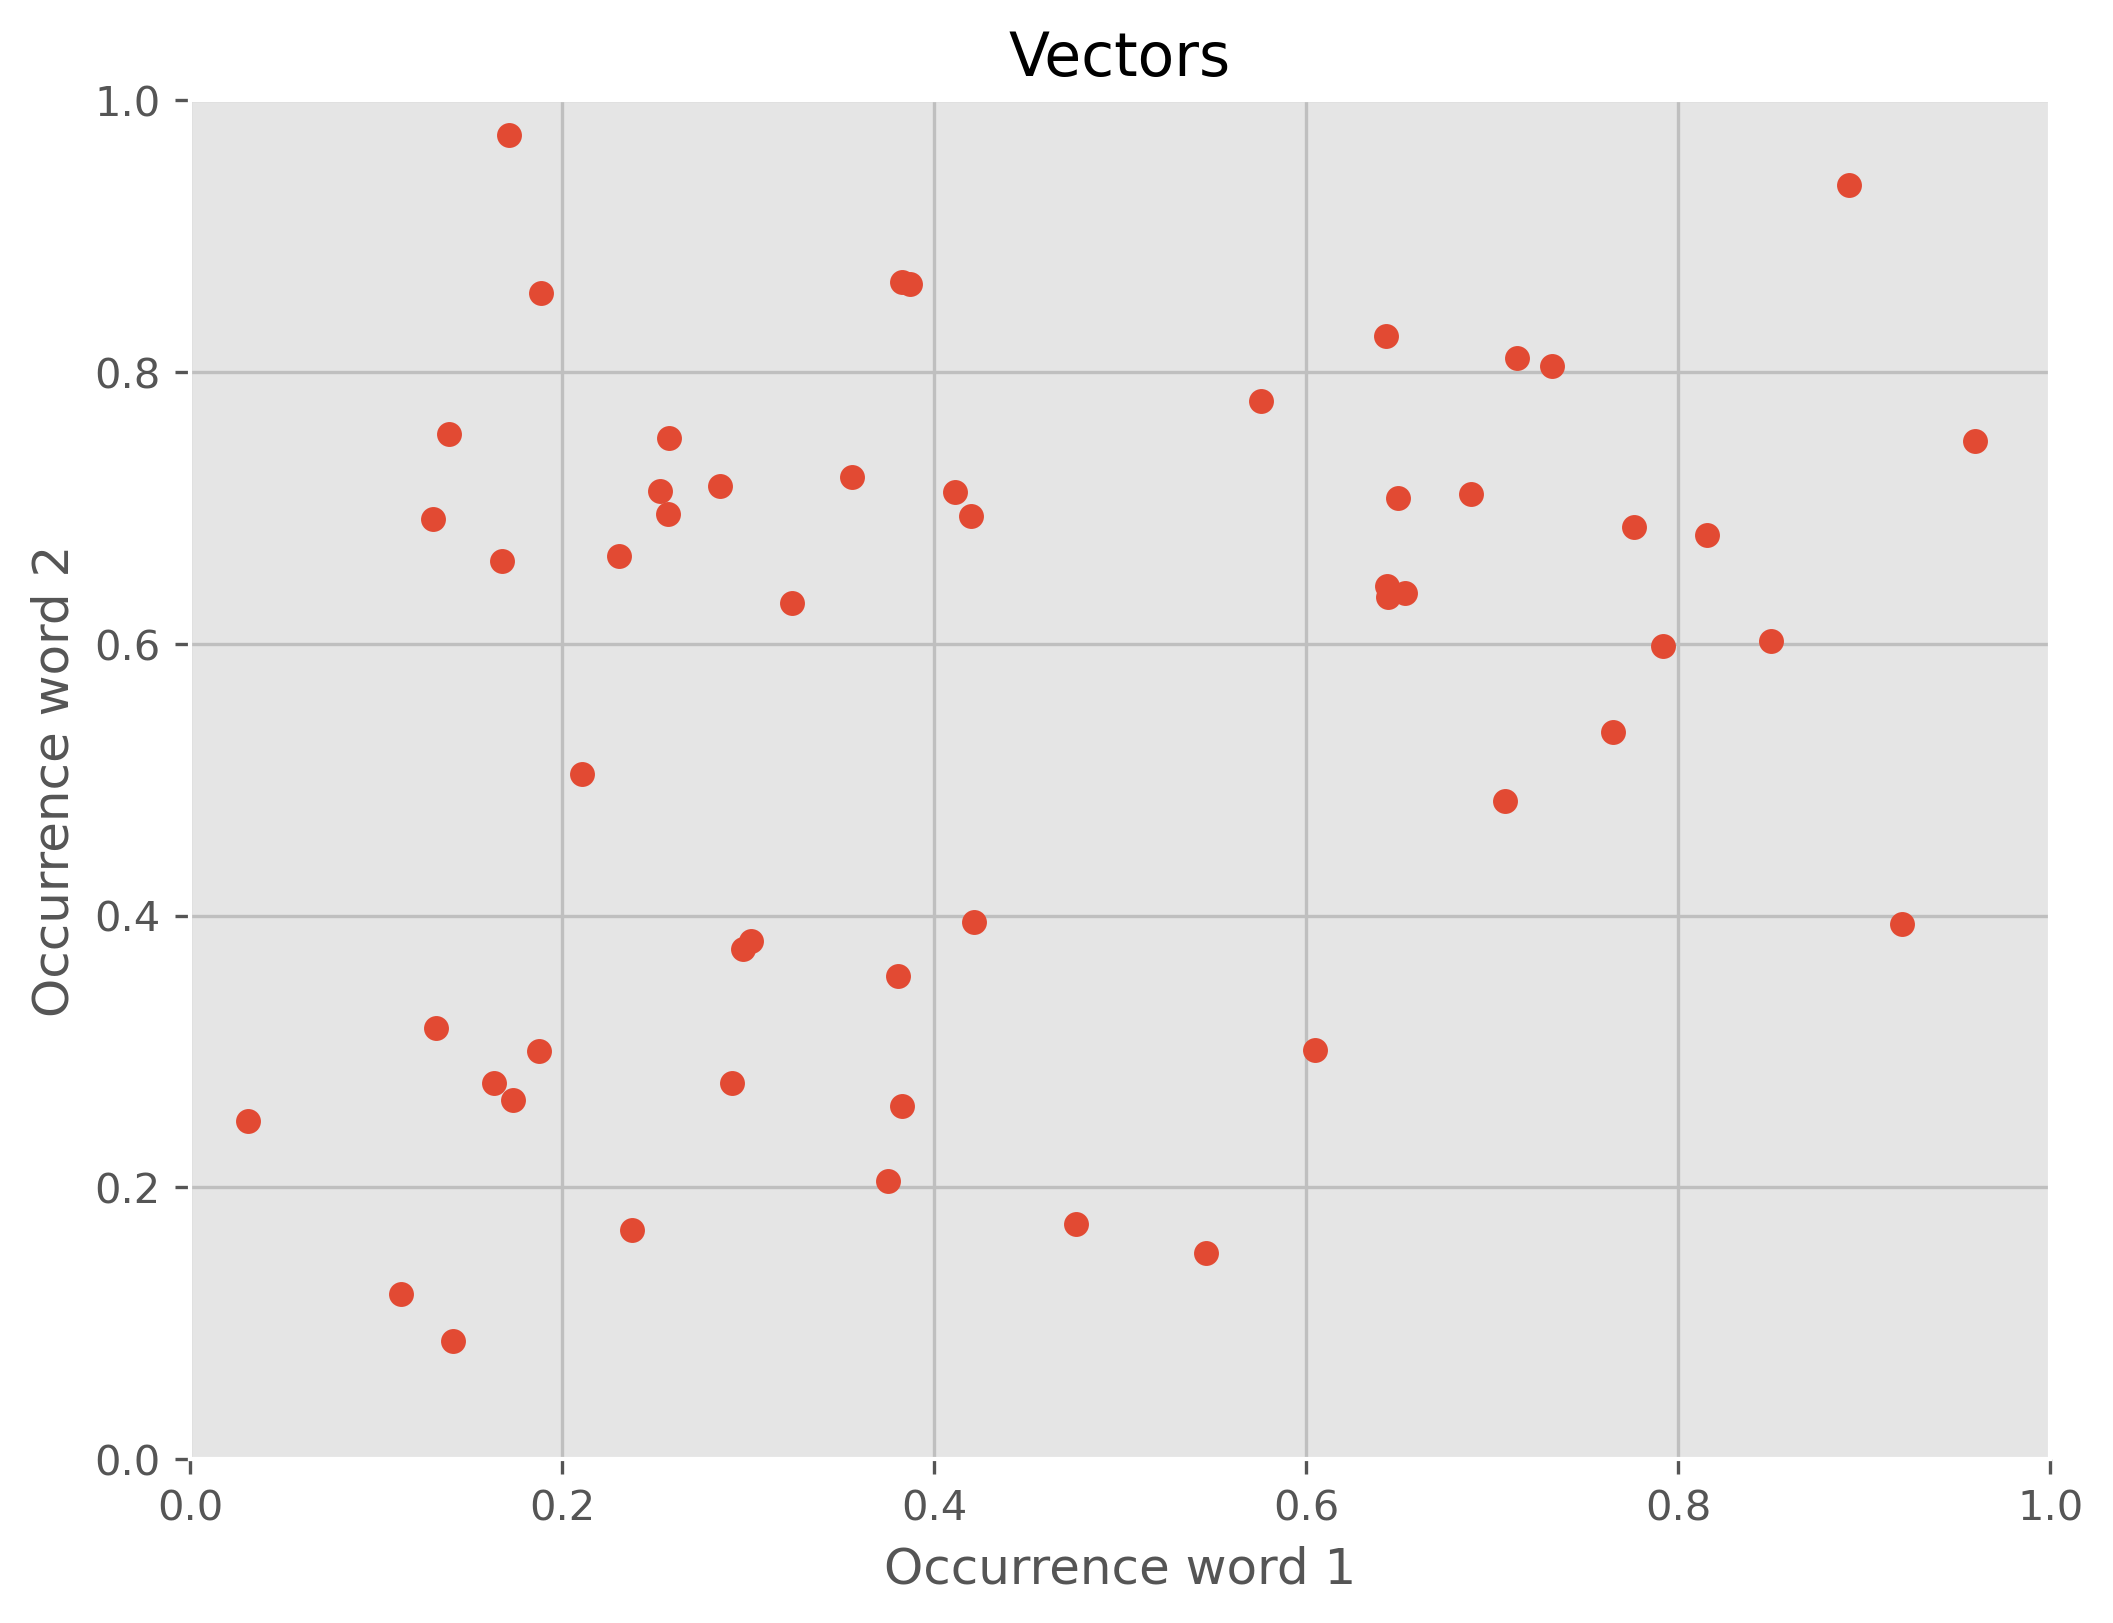

In [35]:
from sklearn.cluster import KMeans

seed = 2
np.random.seed(seed)  # to reproduce the data later on

num_clusters = 3


def plot_clustering(x, y, title, mx=None, ymax=None, xmin=None, km=None):
    plt.figure(num=None, figsize=(8, 6), dpi=DPI)
    if km:
        plt.scatter(x, y, s=30, c=km.predict(list(zip(x, y))))
    else:
        plt.scatter(x, y, s=30)

    plt.title(title)
    plt.xlabel("Occurrence word 1")
    plt.ylabel("Occurrence word 2")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0, ymax=1)
    plt.xlim(xmin=0, xmax=1)
    plt.grid(True, linestyle='-', color='0.75')

    return plt


xw1 = scipy.stats.norm(loc=0.3, scale=.15).rvs(20)
yw1 = scipy.stats.norm(loc=0.3, scale=.15).rvs(20)

xw2 = scipy.stats.norm(loc=0.7, scale=.15).rvs(20)
yw2 = scipy.stats.norm(loc=0.7, scale=.15).rvs(20)

xw3 = scipy.stats.norm(loc=0.2, scale=.15).rvs(20)
yw3 = scipy.stats.norm(loc=0.8, scale=.15).rvs(20)

x = np.append(np.append(xw1, xw2), xw3)
y = np.append(np.append(yw1, yw2), yw3)

plot_clustering(x, y, "Vectors")
save_png("01_clustering_data")

#### Clustering after 1st iteration

After running one iteration of K-means, that is, taking any two vectors as starting points, assigning the labels to the rest, and updating the cluster centers to be the center point of all points in that cluster, we get the following clustering:

Initialization complete
Iteration 0, inertia 4.7485267474116775


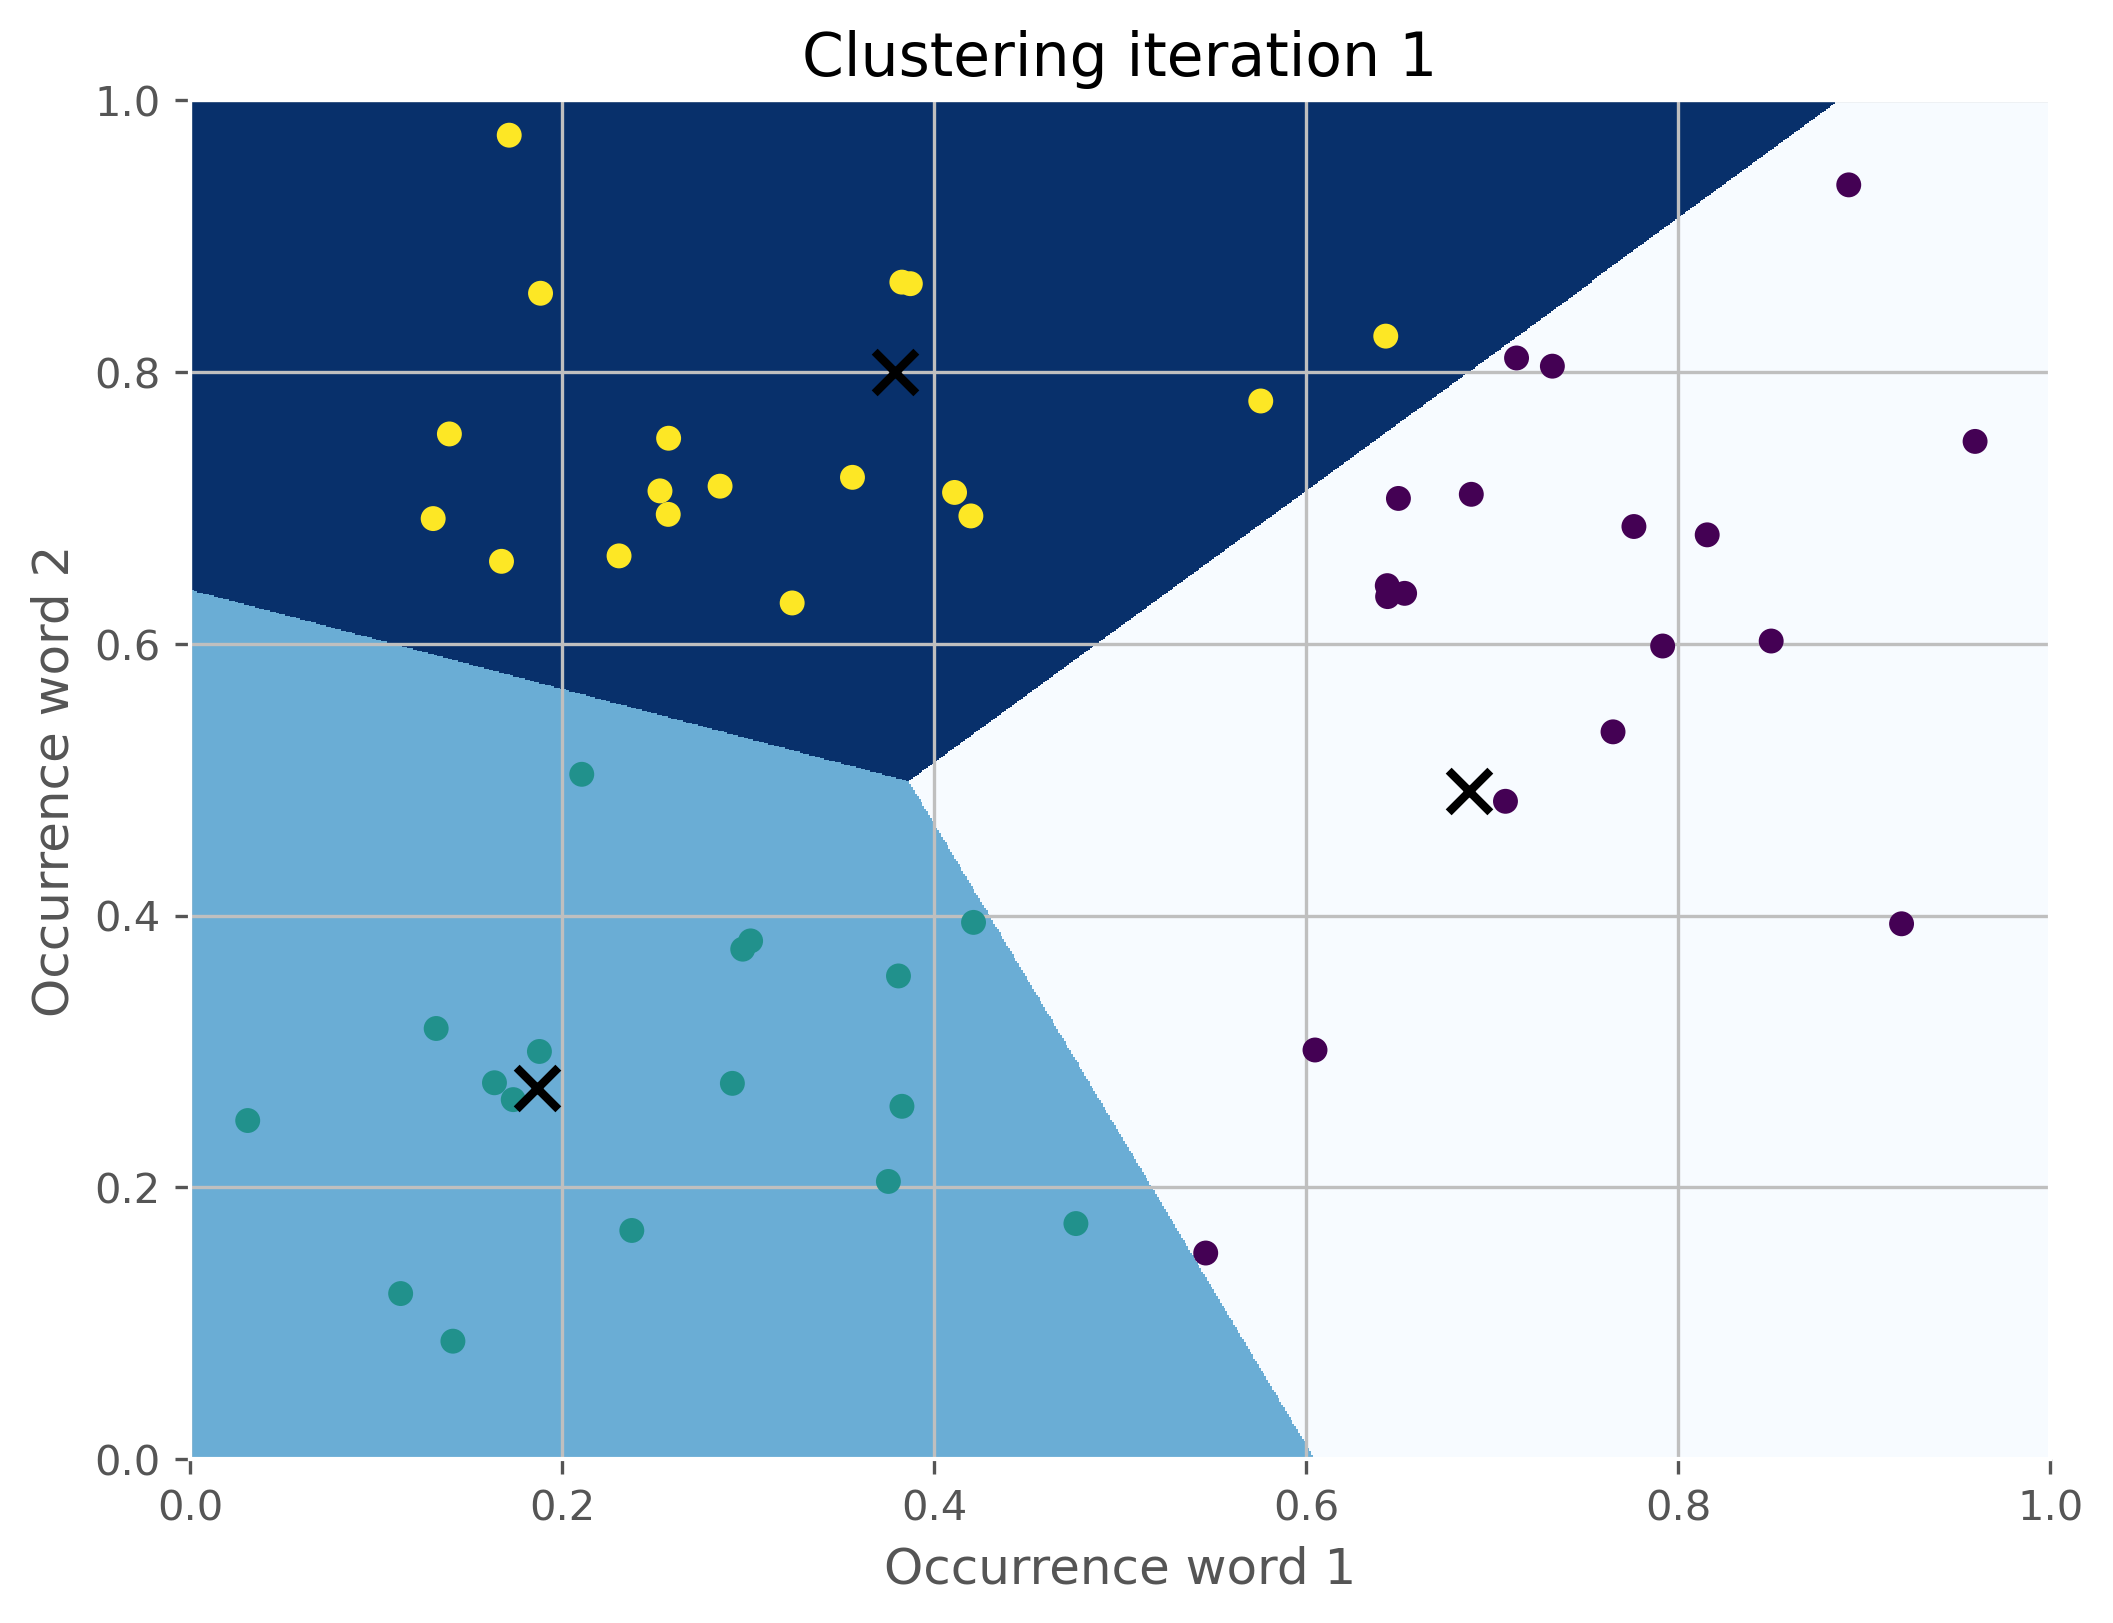

In [36]:
mx, my = np.meshgrid(np.arange(0, 1, 0.001), np.arange(0, 1, 0.001))

km = KMeans(init='random', n_clusters=num_clusters, verbose=1,
            n_init=1, max_iter=1,
            random_state=seed)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 1", km=km)
plt.imshow(Z, interpolation='nearest',
           extent=(mx.min(), mx.max(), my.min(), my.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')

c1a, c1b, c1c = km.cluster_centers_
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
              marker='x', linewidth=2, s=100, color='black')
save_png("02_clustering_iteration_1")

#### Clustering after 2nd iteration

Because the cluster centers moved, we have to reassign the cluster labels and recalculate the cluster centers. After iteration 2, we get the following clustering:

Initialization complete
Iteration 0, inertia 4.7485267474116775
Iteration 1, inertia 3.3787856939654475


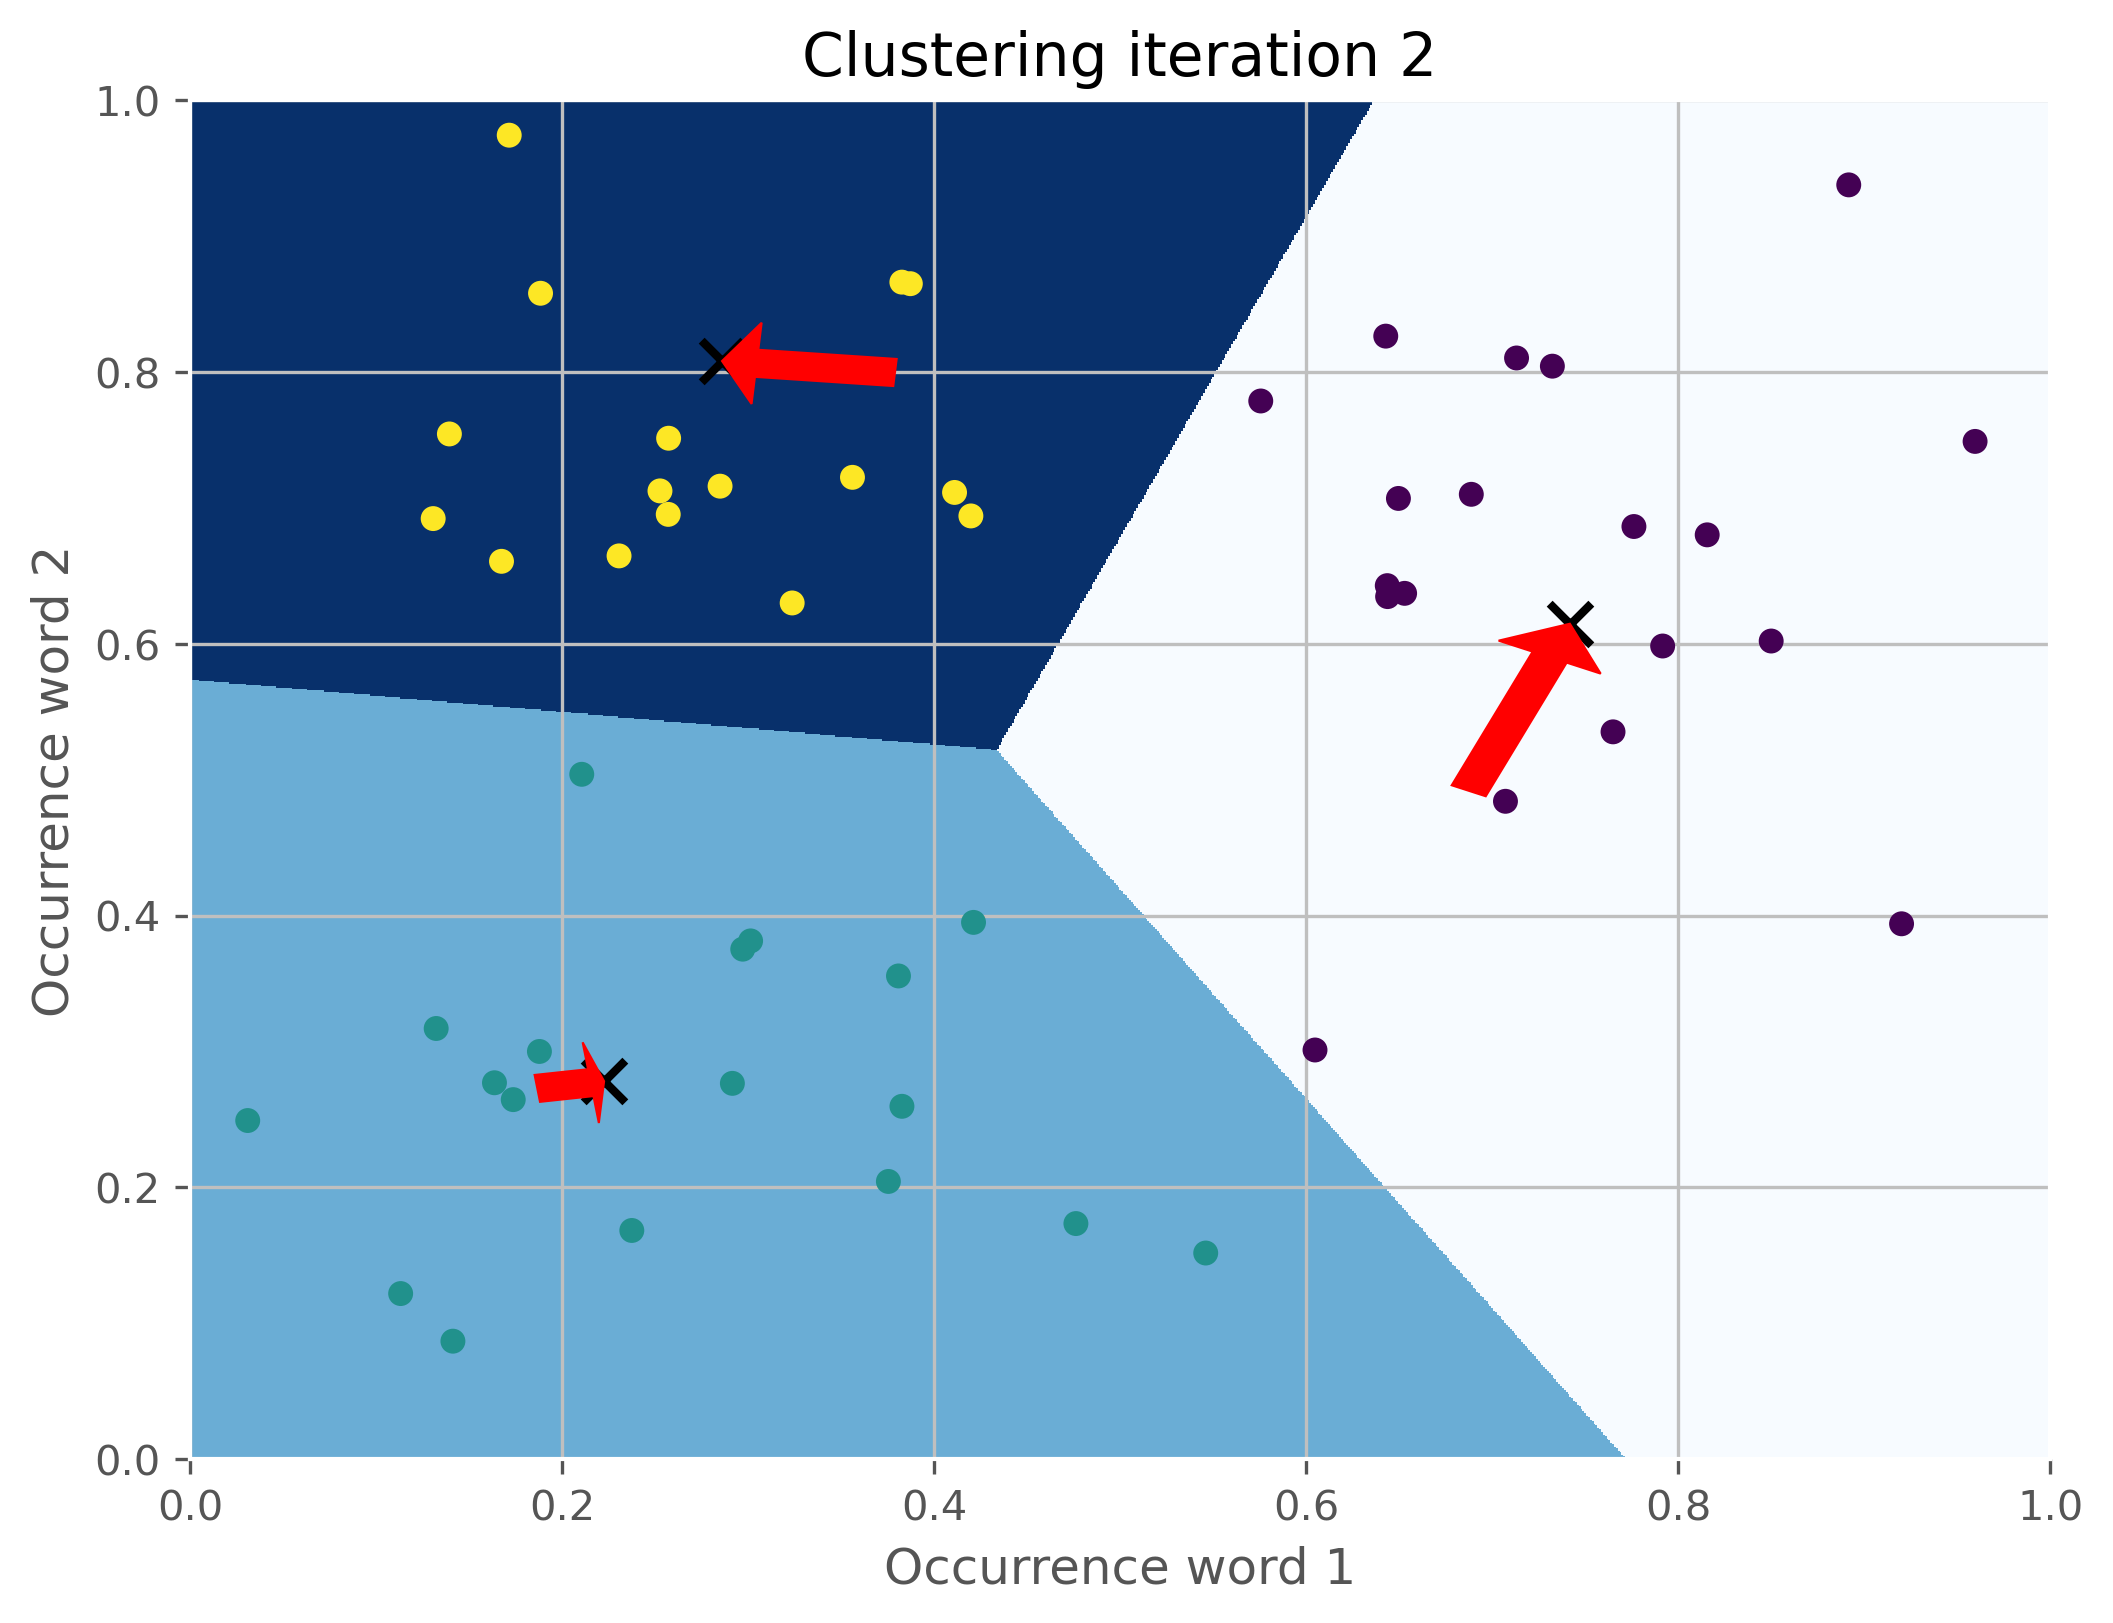

In [37]:
km = KMeans(init='random', n_clusters=num_clusters, verbose=1,
            n_init=1, max_iter=2,
            random_state=seed)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 2", km=km)
plt.imshow(Z, interpolation='nearest',
           extent=(mx.min(), mx.max(), my.min(), my.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')

c2a, c2b, c2c = km.cluster_centers_
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
              marker='x', linewidth=2, s=100, color='black')

plt.gca().add_patch(plt.Arrow(c1a[0], c1a[1], c2a[0] - c1a[0], c2a[1] - c1a[1], width=0.1, color='red'))
plt.gca().add_patch(plt.Arrow(c1b[0], c1b[1], c2b[0] - c1b[0], c2b[1] - c1b[1], width=0.1, color='red'))
plt.gca().add_patch(plt.Arrow(c1c[0], c1c[1], c2c[0] - c1c[0], c2c[1] - c1c[1], width=0.1, color='red'))

save_png("03_clustering_iteration_2")

The arrows show the movements of the cluster centers.

#### Final Clustering

After ten iterations. as shown in the following screenshot of this example, the cluster centers don't move noticeably anymore (scikit's tolerance threshold is 0.0001 by default):

Initialization complete
Iteration 0, inertia 4.7485267474116775
Iteration 1, inertia 3.3787856939654475
Iteration 2, inertia 2.5999573206286968
Iteration 3, inertia 2.496571140237421
Iteration 4, inertia 2.447223016211801
Converged at iteration 4: strict convergence.


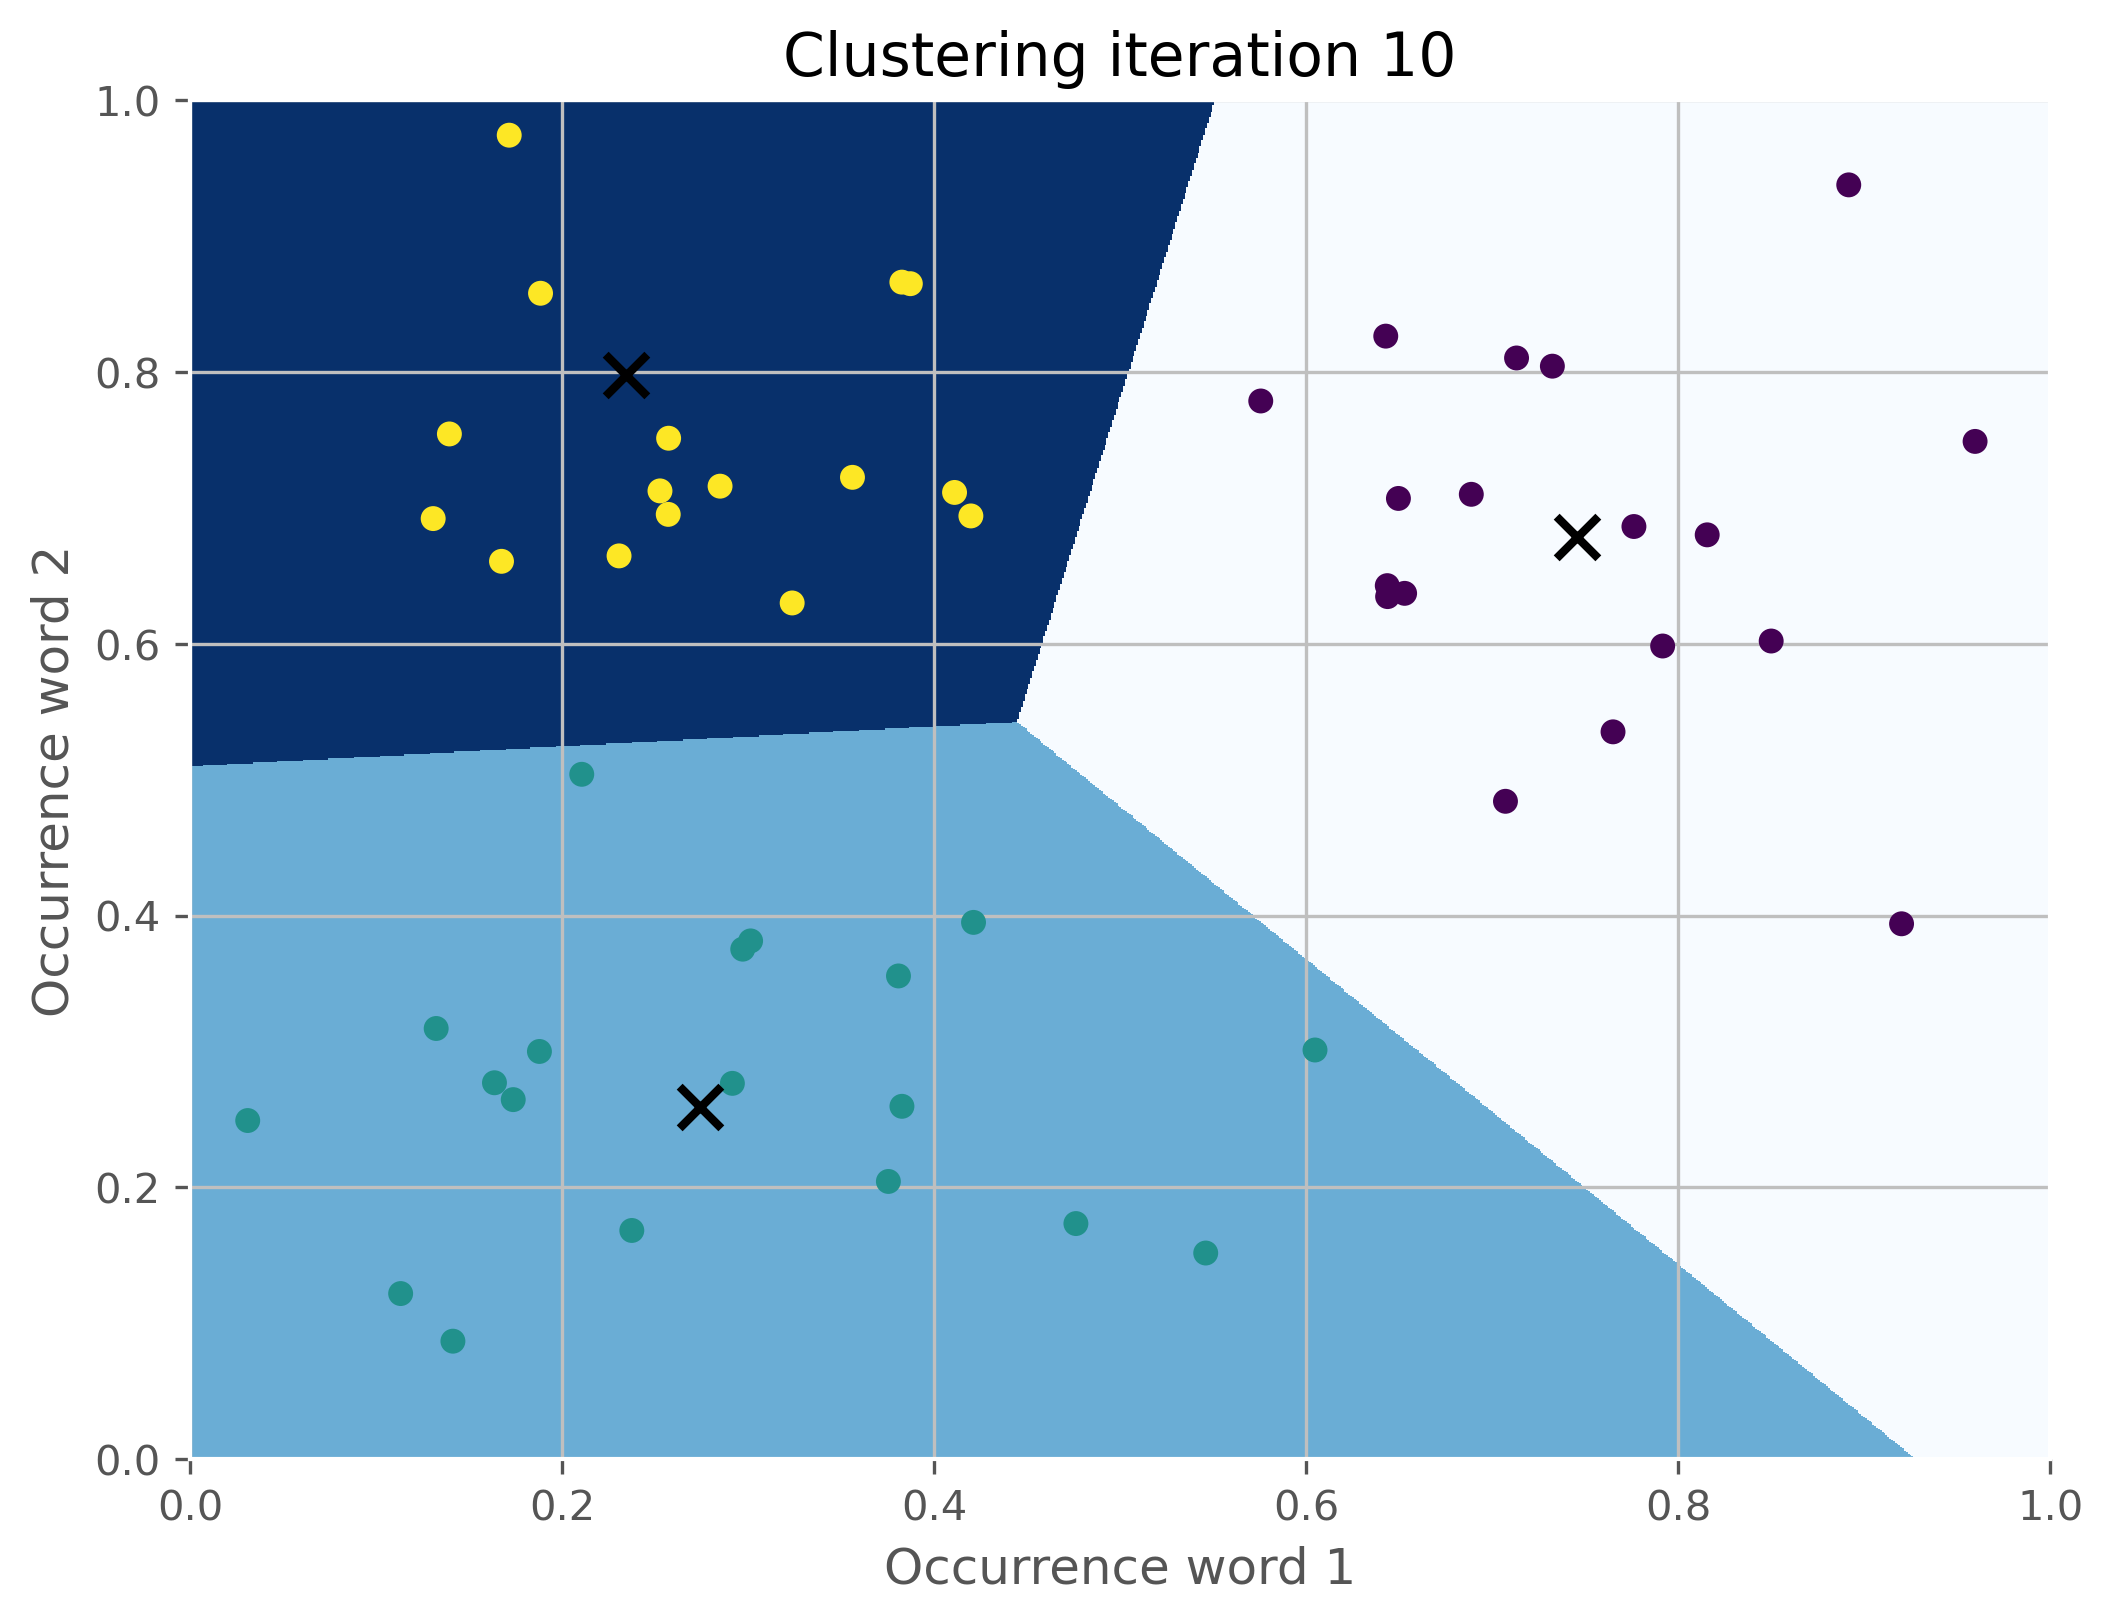

In [38]:
# 10 iterations ####################
km = KMeans(init='random', n_clusters=num_clusters, verbose=1,
            n_init=1, max_iter=10,
            random_state=seed)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 10", km=km)
plt.imshow(Z, interpolation='nearest',
             extent=(mx.min(), mx.max(), my.min(), my.max()),
             cmap=plt.cm.Blues,
             aspect='auto', origin='lower')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
              marker='x', linewidth=2, s=100, color='black')
save_png("04_clustering_iteration_final")

After the clustering has settled, we just need to note down the cluster centers and their cluster number. For each new document that comes in, we then have to vectorize and compare against all cluster centers. The cluster center with the smallest distance to our new post vector belongs to the cluster we will assign to the new post.

## Getting test data to evaluate our ideas

In order to test clustering, we use one standard dataset in machine learning called the _20newsgroup_ dataset, which contains 18,826 posts from 20 different newsgroups. Among the groups' topics are technical ones such as _comp.sys.mac.hardware_ or _sci.crypt_, as well as more politics- and religion-related ones such as _talk.politics.guns_ or _soc.religion.christian_. We will restrict ourselves to the technical groups. If we assume each newsgroup as one cluster, we can nicely test whether our approach of finding related posts works.

For convenience, the _sklearn.datasets_ module also contains the _fetch_20newsgroups_ function, which automatically downloads the data behind the scenes:

In [39]:
import sklearn.datasets
all_data = sklearn.datasets.fetch_20newsgroups(subset='all') 
print(len(all_data.filenames))
print(all_data.target_names)

18846
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [40]:
train_data = sklearn.datasets.fetch_20newsgroups(subset="train")
print(len(train_data.filenames))

test_data = sklearn.datasets.fetch_20newsgroups(subset='test')
print(len(test_data.filenames))

11314
7532


In [41]:
groups = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
          'comp.sys.mac.hardware', 'comp.windows.x', 'sci.space']

train_data = sklearn.datasets.fetch_20newsgroups(subset="train", categories=groups)
print(len(train_data.filenames))

test_data = sklearn.datasets.fetch_20newsgroups(subset='test', categories=groups)
print(len(test_data.filenames))

3529
2349


## Clustering posts

Making the vectorizer ignore noise and invalid characters.

In [42]:
vectorizer = StemmedTfidfVectorizer(min_df=10, max_df=0.5,
                                    stop_words='english', decode_error='ignore')
vectorized = vectorizer.fit_transform(train_data.data)

num_samples, num_features = vectorized.shape
print("#samples: %d, #features: %d" % (num_samples, num_features))

#samples: 3529, #features: 4712


In [43]:
num_clusters = 50  # np.unique(labels).shape[0]

km = KMeans(n_clusters=num_clusters, n_init=1, verbose=1, random_state=3)
clustered = km.fit(vectorized)

Initialization complete
Iteration 0, inertia 5686.052543663701
Iteration 1, inertia 3164.8875140123573
Iteration 2, inertia 3132.207711195148
Iteration 3, inertia 3111.712575878141
Iteration 4, inertia 3098.5837736478657
Iteration 5, inertia 3092.1905280374413
Iteration 6, inertia 3087.277089244311
Iteration 7, inertia 3084.1004773772725
Iteration 8, inertia 3082.799767750703
Iteration 9, inertia 3082.234382617418
Iteration 10, inertia 3081.9487984162015
Iteration 11, inertia 3081.843333964574
Iteration 12, inertia 3081.790665037127
Iteration 13, inertia 3081.7522177638257
Iteration 14, inertia 3081.659718679883
Iteration 15, inertia 3081.61679146951
Iteration 16, inertia 3081.5894842981666
Iteration 17, inertia 3081.5709703035714
Converged at iteration 17: strict convergence.


That's it. We provided a random state just so that you can get the same results. In real-world applications, you will not do this. After fitting, we can get the clustering information out of members of _km_. For every vectorized post that has been fit, there is a corresponding integer label in _km.labels__:

In [44]:
print("km.labels_=%s" % km.labels_)
print("km.labels_.shape=%s" % km.labels_.shape)

km.labels_=[48 23 31 ...  6  2 22]
km.labels_.shape=3529


## Solving our initial challenge

We will now put everything together and demonstrate our system for the following new post that we assign to the _new_post_ variable:

In [45]:
new_post = '''\
Disk drive problems. Hi, I have a problem with my hard disk.
After 1 year it is working only sporadically now.
I tried to format it, but now it doesn't boot any more.
Any ideas? Thanks.
'''

new_post_vec = vectorizer.transform([new_post])
new_post_label = km.predict(new_post_vec)[0]

similar_indices = (km.labels_ == new_post_label).nonzero()[0]

similar = []
for i in similar_indices:
    dist = scipy.linalg.norm((new_post_vec - vectorized[i]).toarray())
    similar.append((dist, train_data.data[i]))

In [46]:
similar = sorted(similar)
print("Count similar: %i" % len(similar))

Count similar: 56


We found 56 posts in the cluster of our post. To give the user a quick idea of what kind of similar posts are available, we can now present the most similar post (show_at_1), and two less similar but still related ones, all from the same cluster:

In [47]:
show_at_1 = similar[0]
show_at_2 = similar[len(similar) // 10]
show_at_3 = similar[len(similar) // 2]

print("=== #1 ===")
print(show_at_1)
print()

print("=== #2 ===")
print(show_at_2)
print()

print("=== #3 ===")
print(show_at_3)

=== #1 ===
(1.0378441731334072, "From: Thomas Dachsel <GERTHD@mvs.sas.com>\nSubject: BOOT PROBLEM with IDE controller\nNntp-Posting-Host: sdcmvs.mvs.sas.com\nOrganization: SAS Institute Inc.\nLines: 25\n\nHi,\nI've got a Multi I/O card (IDE controller + serial/parallel\ninterface) and two floppy drives (5 1/4, 3 1/2) and a\nQuantum ProDrive 80AT connected to it.\nI was able to format the hard disk, but I could not boot from\nit. I can boot from drive A: (which disk drive does not matter)\nbut if I remove the disk from drive A and press the reset switch,\nthe LED of drive A: continues to glow, and the hard disk is\nnot accessed at all.\nI guess this must be a problem of either the Multi I/o card\nor floppy disk drive settings (jumper configuration?)\nDoes someone have any hint what could be the reason for it.\nPlease reply by email to GERTHD@MVS.SAS.COM\nThanks,\nThomas\n+-------------------------------------------------------------------+\n| Thomas Dachsel                              

It is interesting that the posts reflect the similarity measurement score. The first post contains all the salient words from our new post. The second also revolves around booting problems but is about floppy disks and not hard disks. Finally, the third is neither about hard disks nor about booting problems. Still, all the posts, we would say, belong to the same domain as the new post.

#### Looking at noise again

The following example gives us a quick impression of the noise that we can expect from clustering. We cannot expect perfect clustering in the sense that posts from the same newsgroup(for example, _comp.graphics_) are clustered together.  

In [48]:
post_group = zip(train_data.data, train_data.target)

# Create a list of tuples that can be sorted by
# the length of the posts
all = [(len(post[0]), post[0], train_data.target_names[post[1]])
       for post in post_group]
graphics = sorted([post for post in all if post[2] == 'comp.graphics'])
print(graphics[5])

(245, 'From: SITUNAYA@IBM3090.BHAM.AC.UK\nSubject: test....(sorry)\nOrganization: The University of Birmingham, United Kingdom\nLines: 1\nNNTP-Posting-Host: ibm3090.bham.ac.uk\n\n==============================================================================\n', 'comp.graphics')


For this post, there is no real indication that it belongs to comp.graphics, considering only the wording that is left after the preprocessing step:

In [49]:
noise_post = graphics[5][1]

analyzer = vectorizer.build_analyzer()
print(list(analyzer(noise_post)))

['situnaya', 'ibm3090', 'bham', 'ac', 'uk', 'subject', 'test', 'sorri', 'organ', 'univers', 'birmingham', 'unit', 'kingdom', 'line', 'nntp', 'post', 'host', 'ibm3090', 'bham', 'ac', 'uk']


We received these words after applying tokenization, lowercasing, and stop word removal. If we also subtract those words that will be later filtered out via _min_df_ and _max_df_, which will be done
later in _fit_transform_, it gets even worse:

In [50]:
useful = set(analyzer(noise_post)).intersection(vectorizer.get_feature_names_out())
print(sorted(useful))

['ac', 'birmingham', 'host', 'kingdom', 'nntp', 'sorri', 'test', 'uk', 'unit', 'univers']


Most of the words occur frequently in other posts as well, as we can see from the IDF scores. Remember that the higher the TF-IDF, the more discriminative a term is for a given post. As IDF is a multiplicative factor here, a low value of it signals that it is not of great value in general:

In [51]:
for term in sorted(useful):
    print('IDF(%-10s) = %.2f' % (term, vectorizer._tfidf.idf_[vectorizer.vocabulary_[term]]))

IDF(ac        ) = 3.51
IDF(birmingham) = 6.77
IDF(host      ) = 1.74
IDF(kingdom   ) = 6.68
IDF(nntp      ) = 1.77
IDF(sorri     ) = 4.14
IDF(test      ) = 3.83
IDF(uk        ) = 3.70
IDF(unit      ) = 4.42
IDF(univers   ) = 1.91


So, the terms with the highest discriminative power, _birmingham_ and _kingdom_, are clearly not that computer graphics related, as is the case with the terms with lower IDF scores. Understandably, posts from different newsgroups will be clustered together.

For our goal, however, this is no big deal, as we are only interested in cutting down the number of posts that we have to compare a new post to. After all, the particular newsgroup that our training data came from is of no special interest.

## Tweaking the parameters(Setting the number of clusters=4)

We could now tweak other parameters to get a better result if we can define what better actually means. We could, for instance, tweak the number of clusters, or play with the vectorizer's _max_features_ parameter. Also, we can play with different cluster center initializations. Then there are more exciting alternatives to K-means itself. There are, for example, clustering approaches that let us use different similarity measurements, such as Cosine similarity, Pearson, or Jaccard.

<module 'matplotlib.pyplot' from 'C:\\Users\\image\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

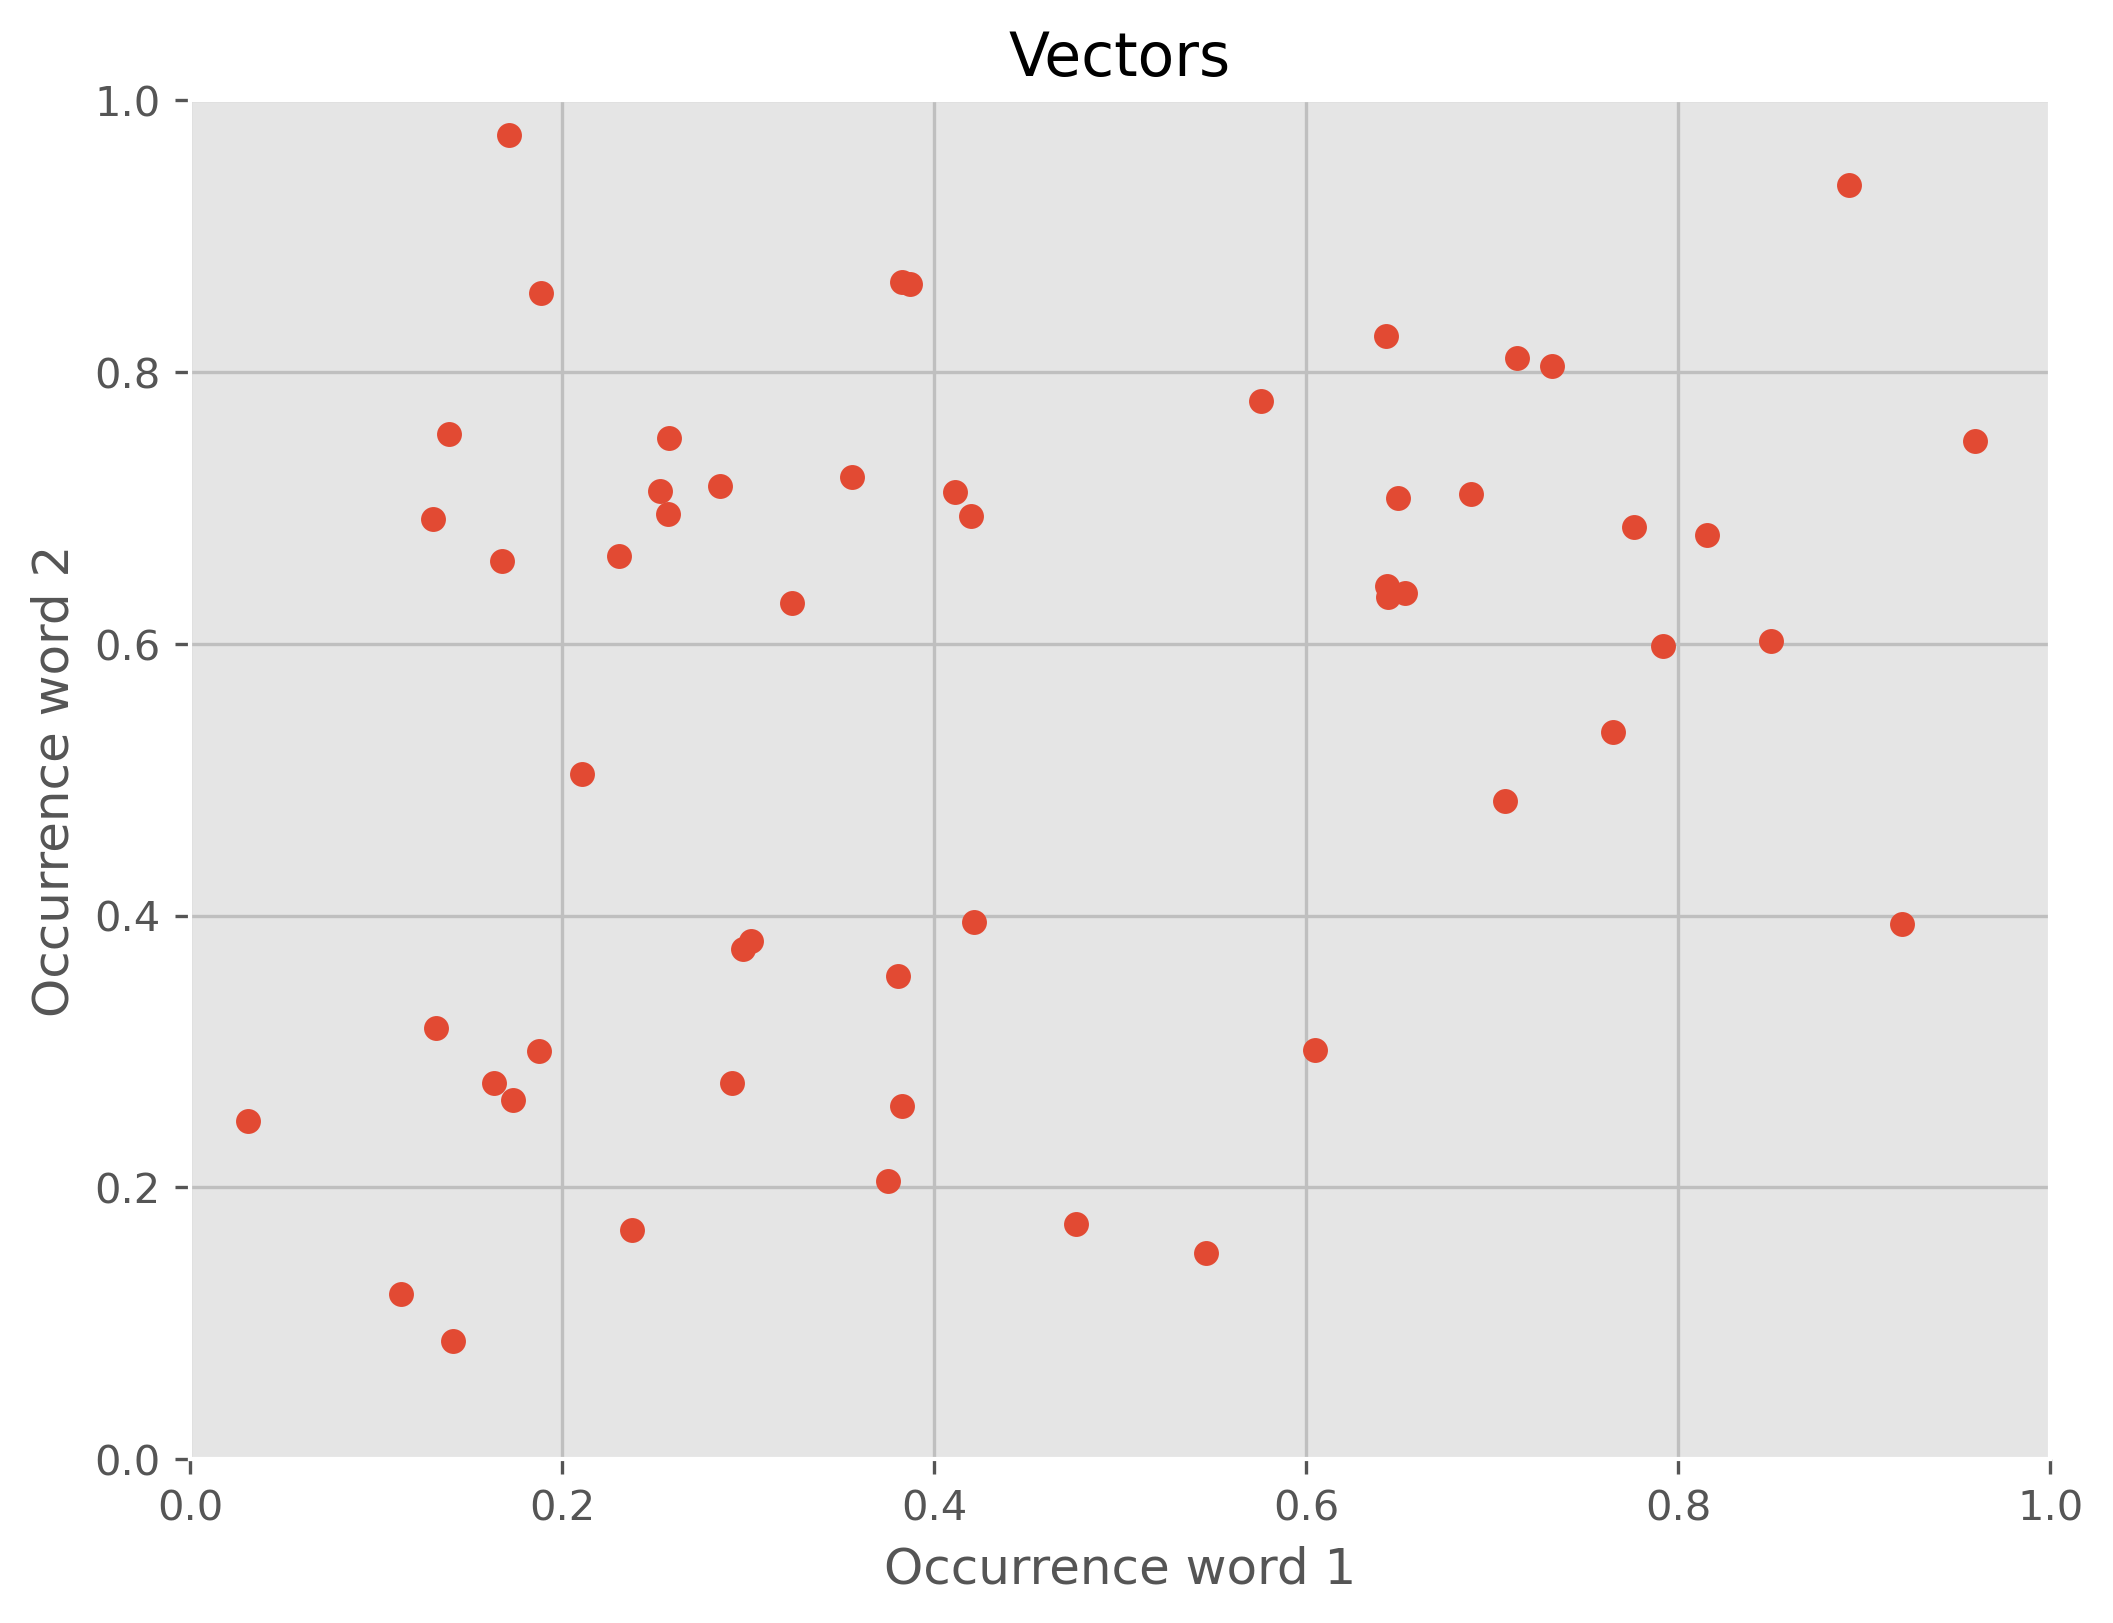

In [52]:
from sklearn.cluster import KMeans

seed = 2
np.random.seed(seed)

num_clusters = 4


def plot_clustering(x, y, title, mx=None, ymax=None, xmin=None, km=None):
    plt.figure(num=None, figsize=(8, 6), dpi=DPI)
    if km:
        plt.scatter(x, y, s=30, c=km.predict(list(zip(x, y))))
    else:
        plt.scatter(x, y, s=30)

    plt.title(title)
    plt.xlabel("Occurrence word 1")
    plt.ylabel("Occurrence word 2")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0, ymax=1)
    plt.xlim(xmin=0, xmax=1)
    plt.grid(True, linestyle='-', color='0.75')

    return plt


xw1 = scipy.stats.norm(loc=0.3, scale=.15).rvs(20)
yw1 = scipy.stats.norm(loc=0.3, scale=.15).rvs(20)

xw2 = scipy.stats.norm(loc=0.7, scale=.15).rvs(20)
yw2 = scipy.stats.norm(loc=0.7, scale=.15).rvs(20)

xw3 = scipy.stats.norm(loc=0.2, scale=.15).rvs(20)
yw3 = scipy.stats.norm(loc=0.8, scale=.15).rvs(20)

x = np.append(np.append(xw1, xw2), xw3)
y = np.append(np.append(yw1, yw2), yw3)

plot_clustering(x, y, "Vectors")

Initialization complete
Iteration 0, inertia 4.153078972649606


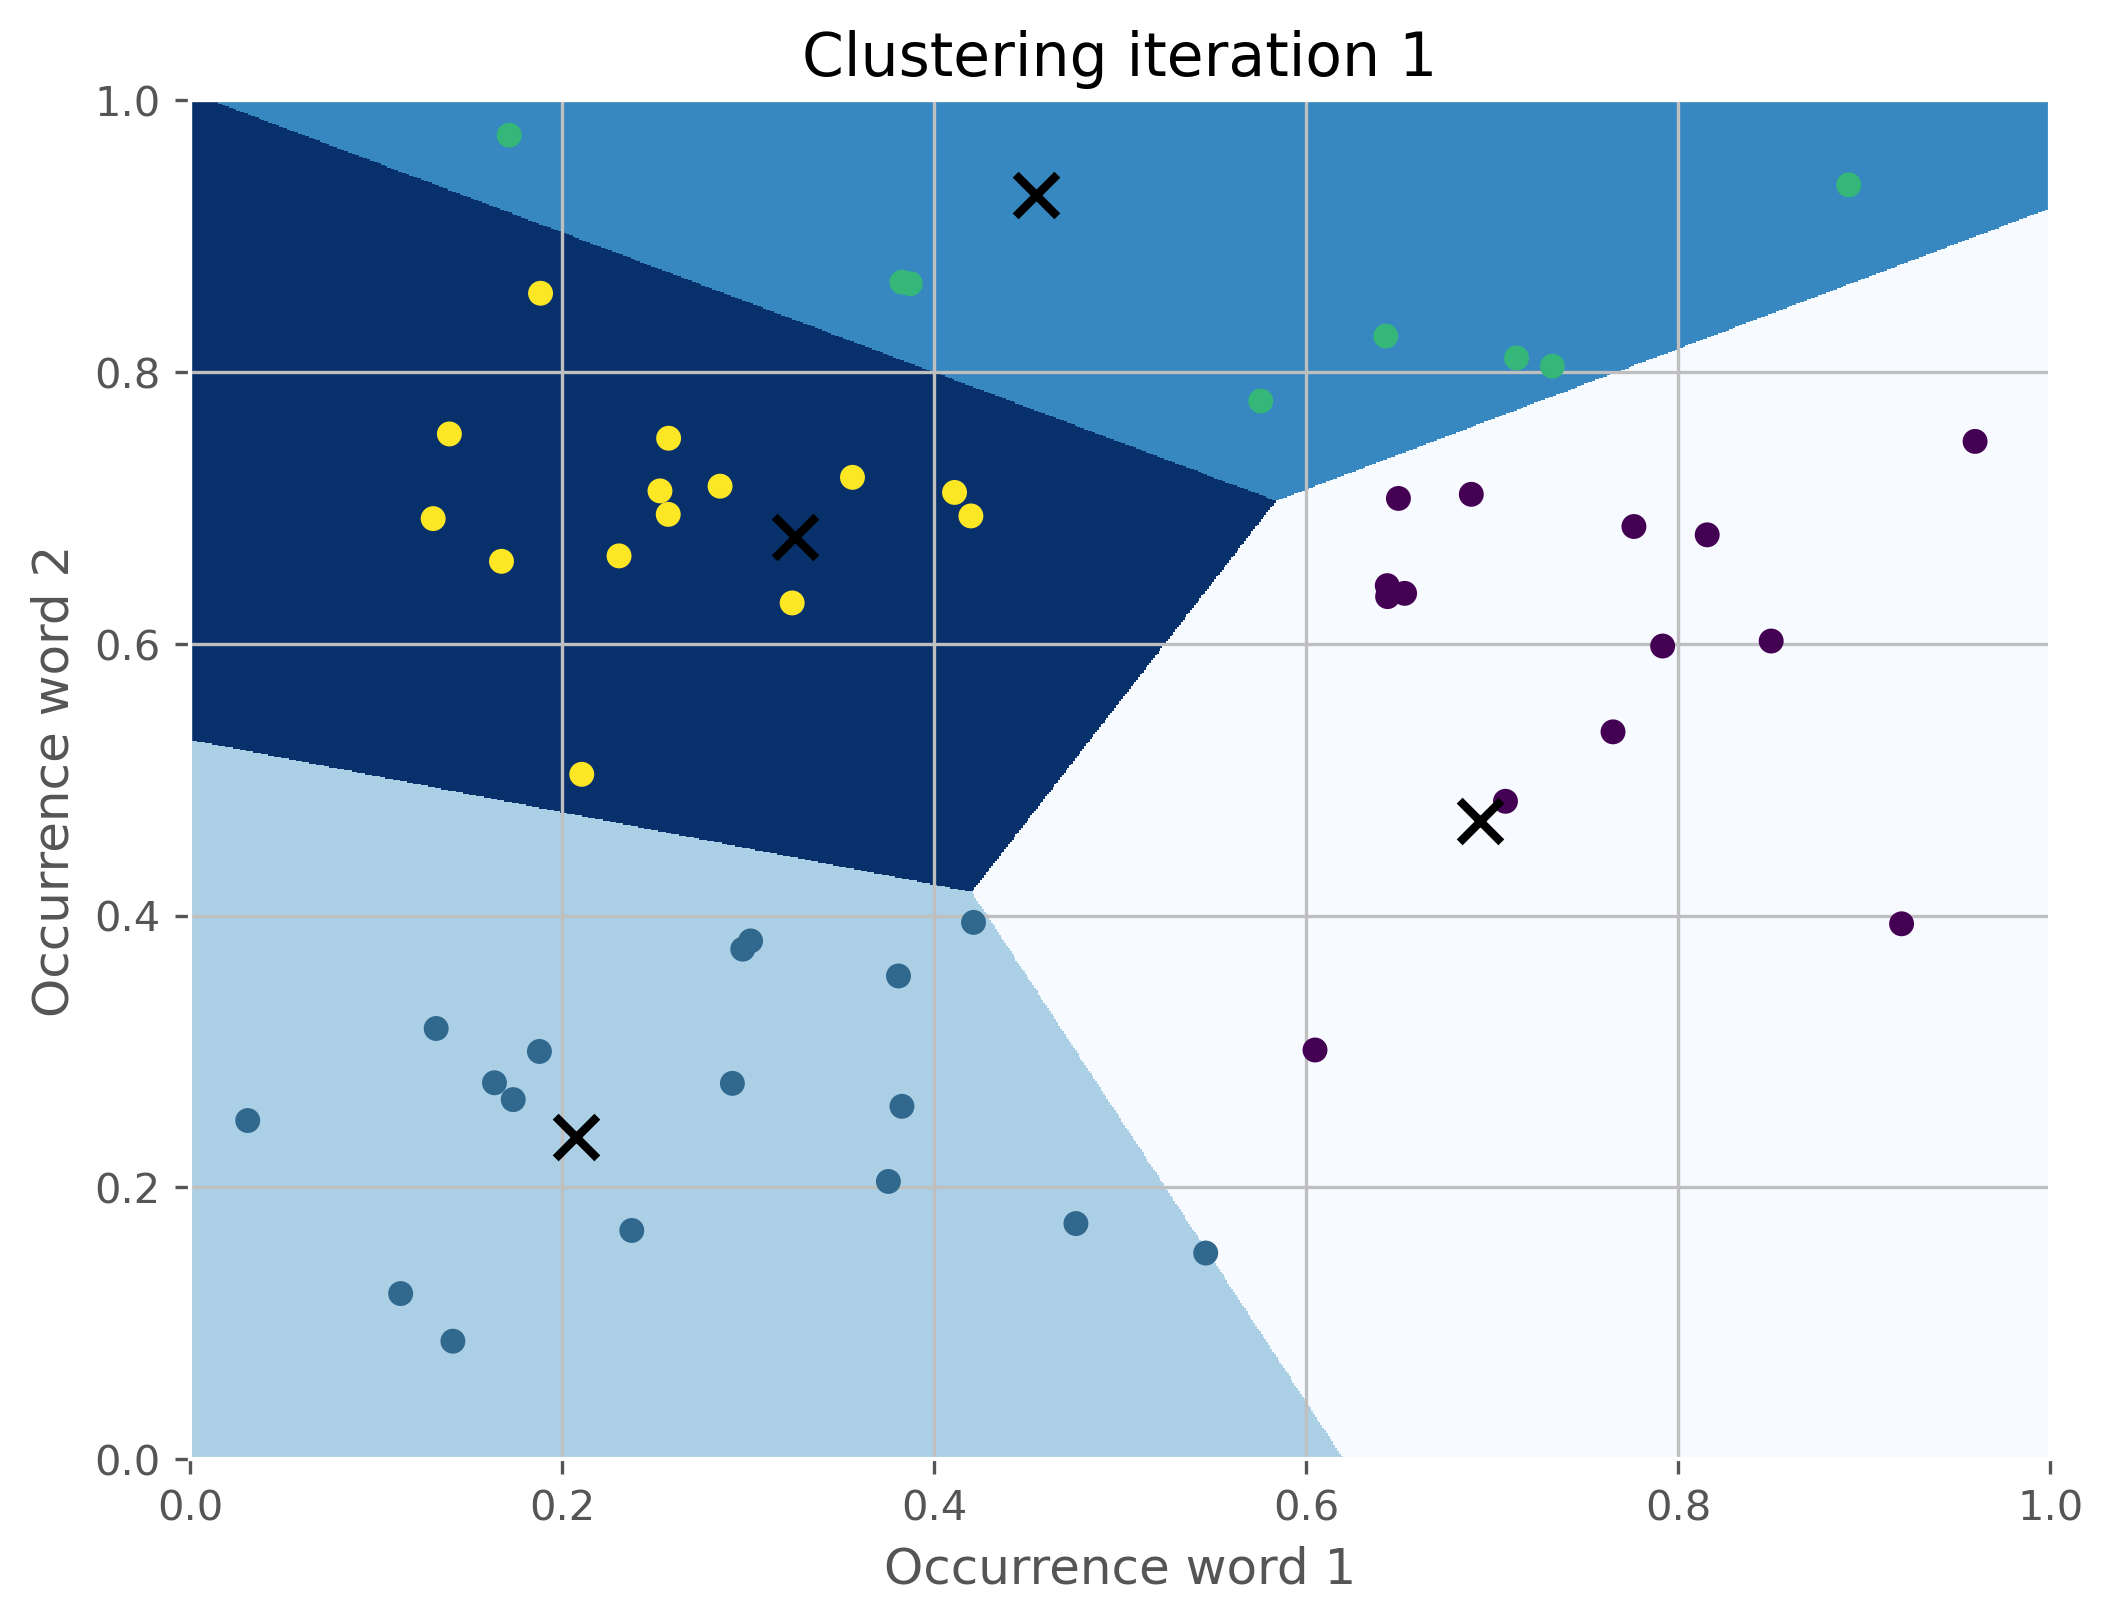

In [54]:
mx, my = np.meshgrid(np.arange(0, 1, 0.001), np.arange(0, 1, 0.001))

km = KMeans(init='random', n_clusters=num_clusters, verbose=1,
            n_init=1, max_iter=1,
            random_state=seed)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 1", km=km)
plt.imshow(Z, interpolation='nearest',
           extent=(mx.min(), mx.max(), my.min(), my.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')

c1a, c1b, c1c,c1d = km.cluster_centers_
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
              marker='x', linewidth=2, s=100, color='black')

Initialization complete
Iteration 0, inertia 4.153078972649606
Iteration 1, inertia 2.9207581550965207


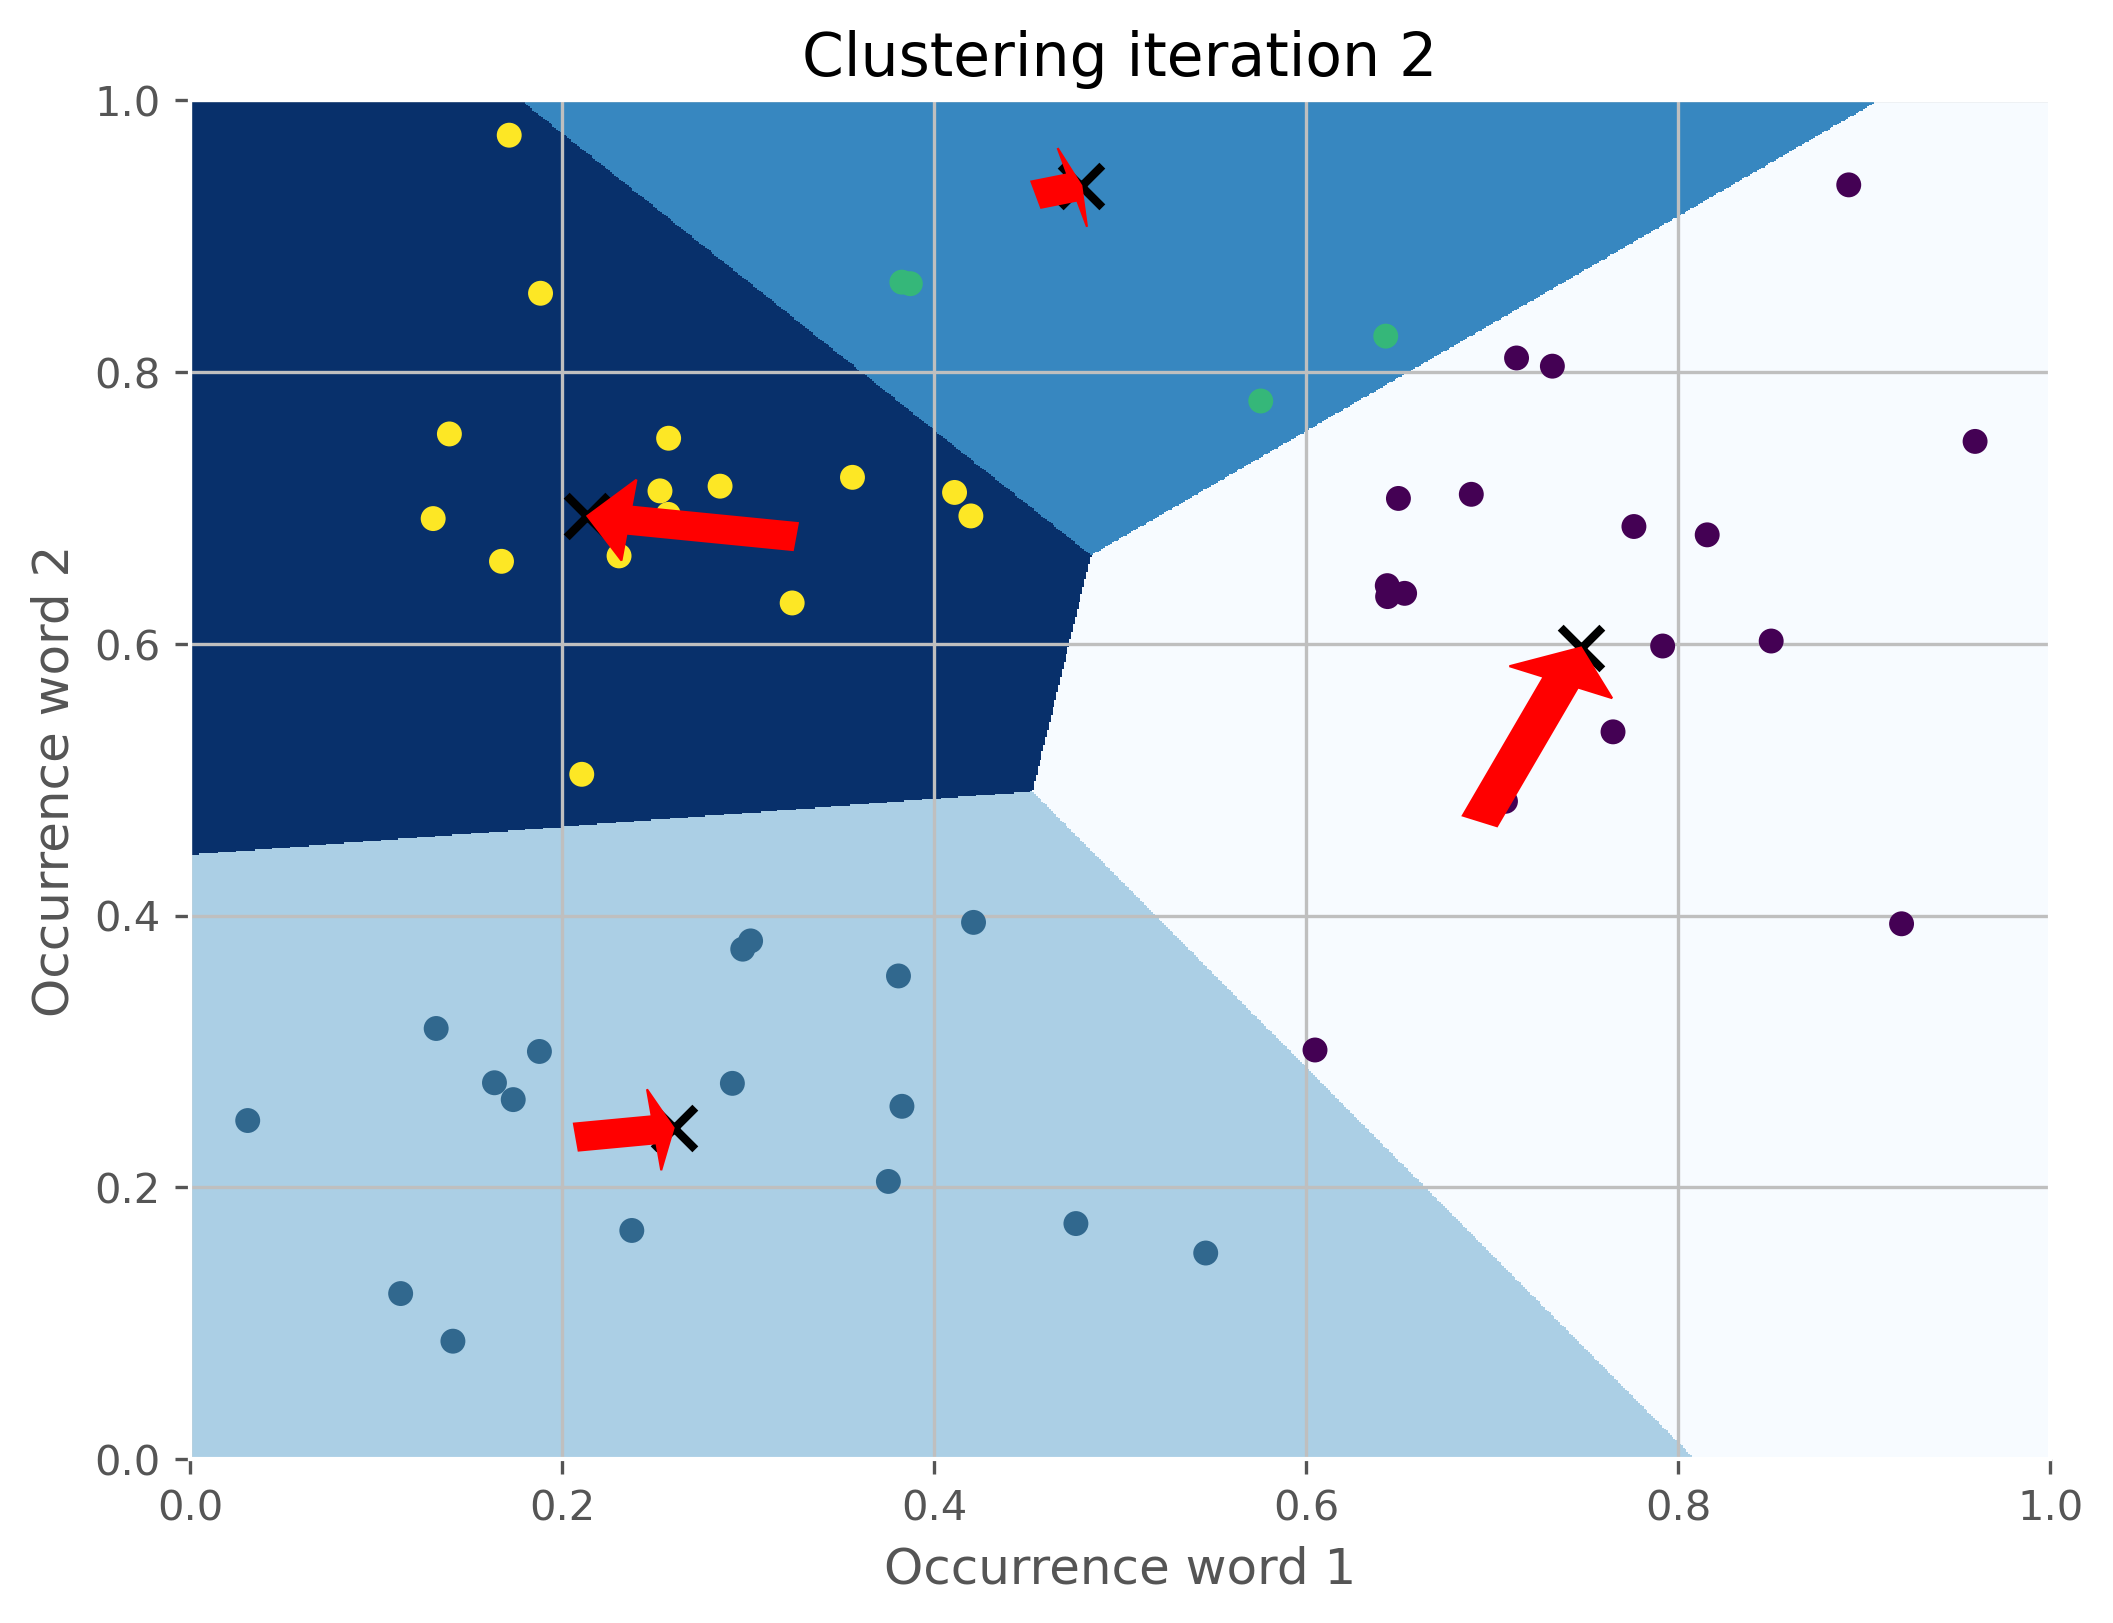

In [56]:
km = KMeans(init='random', n_clusters=num_clusters, verbose=1,
            n_init=1, max_iter=2,
            random_state=seed)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 2", km=km)
plt.imshow(Z, interpolation='nearest',
           extent=(mx.min(), mx.max(), my.min(), my.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')

c2a, c2b, c2c,c2d = km.cluster_centers_
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
              marker='x', linewidth=2, s=100, color='black')

plt.gca().add_patch(plt.Arrow(c1a[0], c1a[1], c2a[0] - c1a[0], c2a[1] - c1a[1], width=0.1, color='red'))
plt.gca().add_patch(plt.Arrow(c1b[0], c1b[1], c2b[0] - c1b[0], c2b[1] - c1b[1], width=0.1, color='red'))
plt.gca().add_patch(plt.Arrow(c1c[0], c1c[1], c2c[0] - c1c[0], c2c[1] - c1c[1], width=0.1, color='red'))
plt.gca().add_patch(plt.Arrow(c1d[0], c1d[1], c2d[0] - c1d[0], c2d[1] - c1d[1], width=0.1, color='red'))

Initialization complete
Iteration 0, inertia 4.153078972649606
Iteration 1, inertia 2.9207581550965207
Iteration 2, inertia 2.2686949733955113
Iteration 3, inertia 2.178972110372303
Iteration 4, inertia 2.1610828946330987
Iteration 5, inertia 2.1367292374009668
Iteration 6, inertia 1.9697212155941375


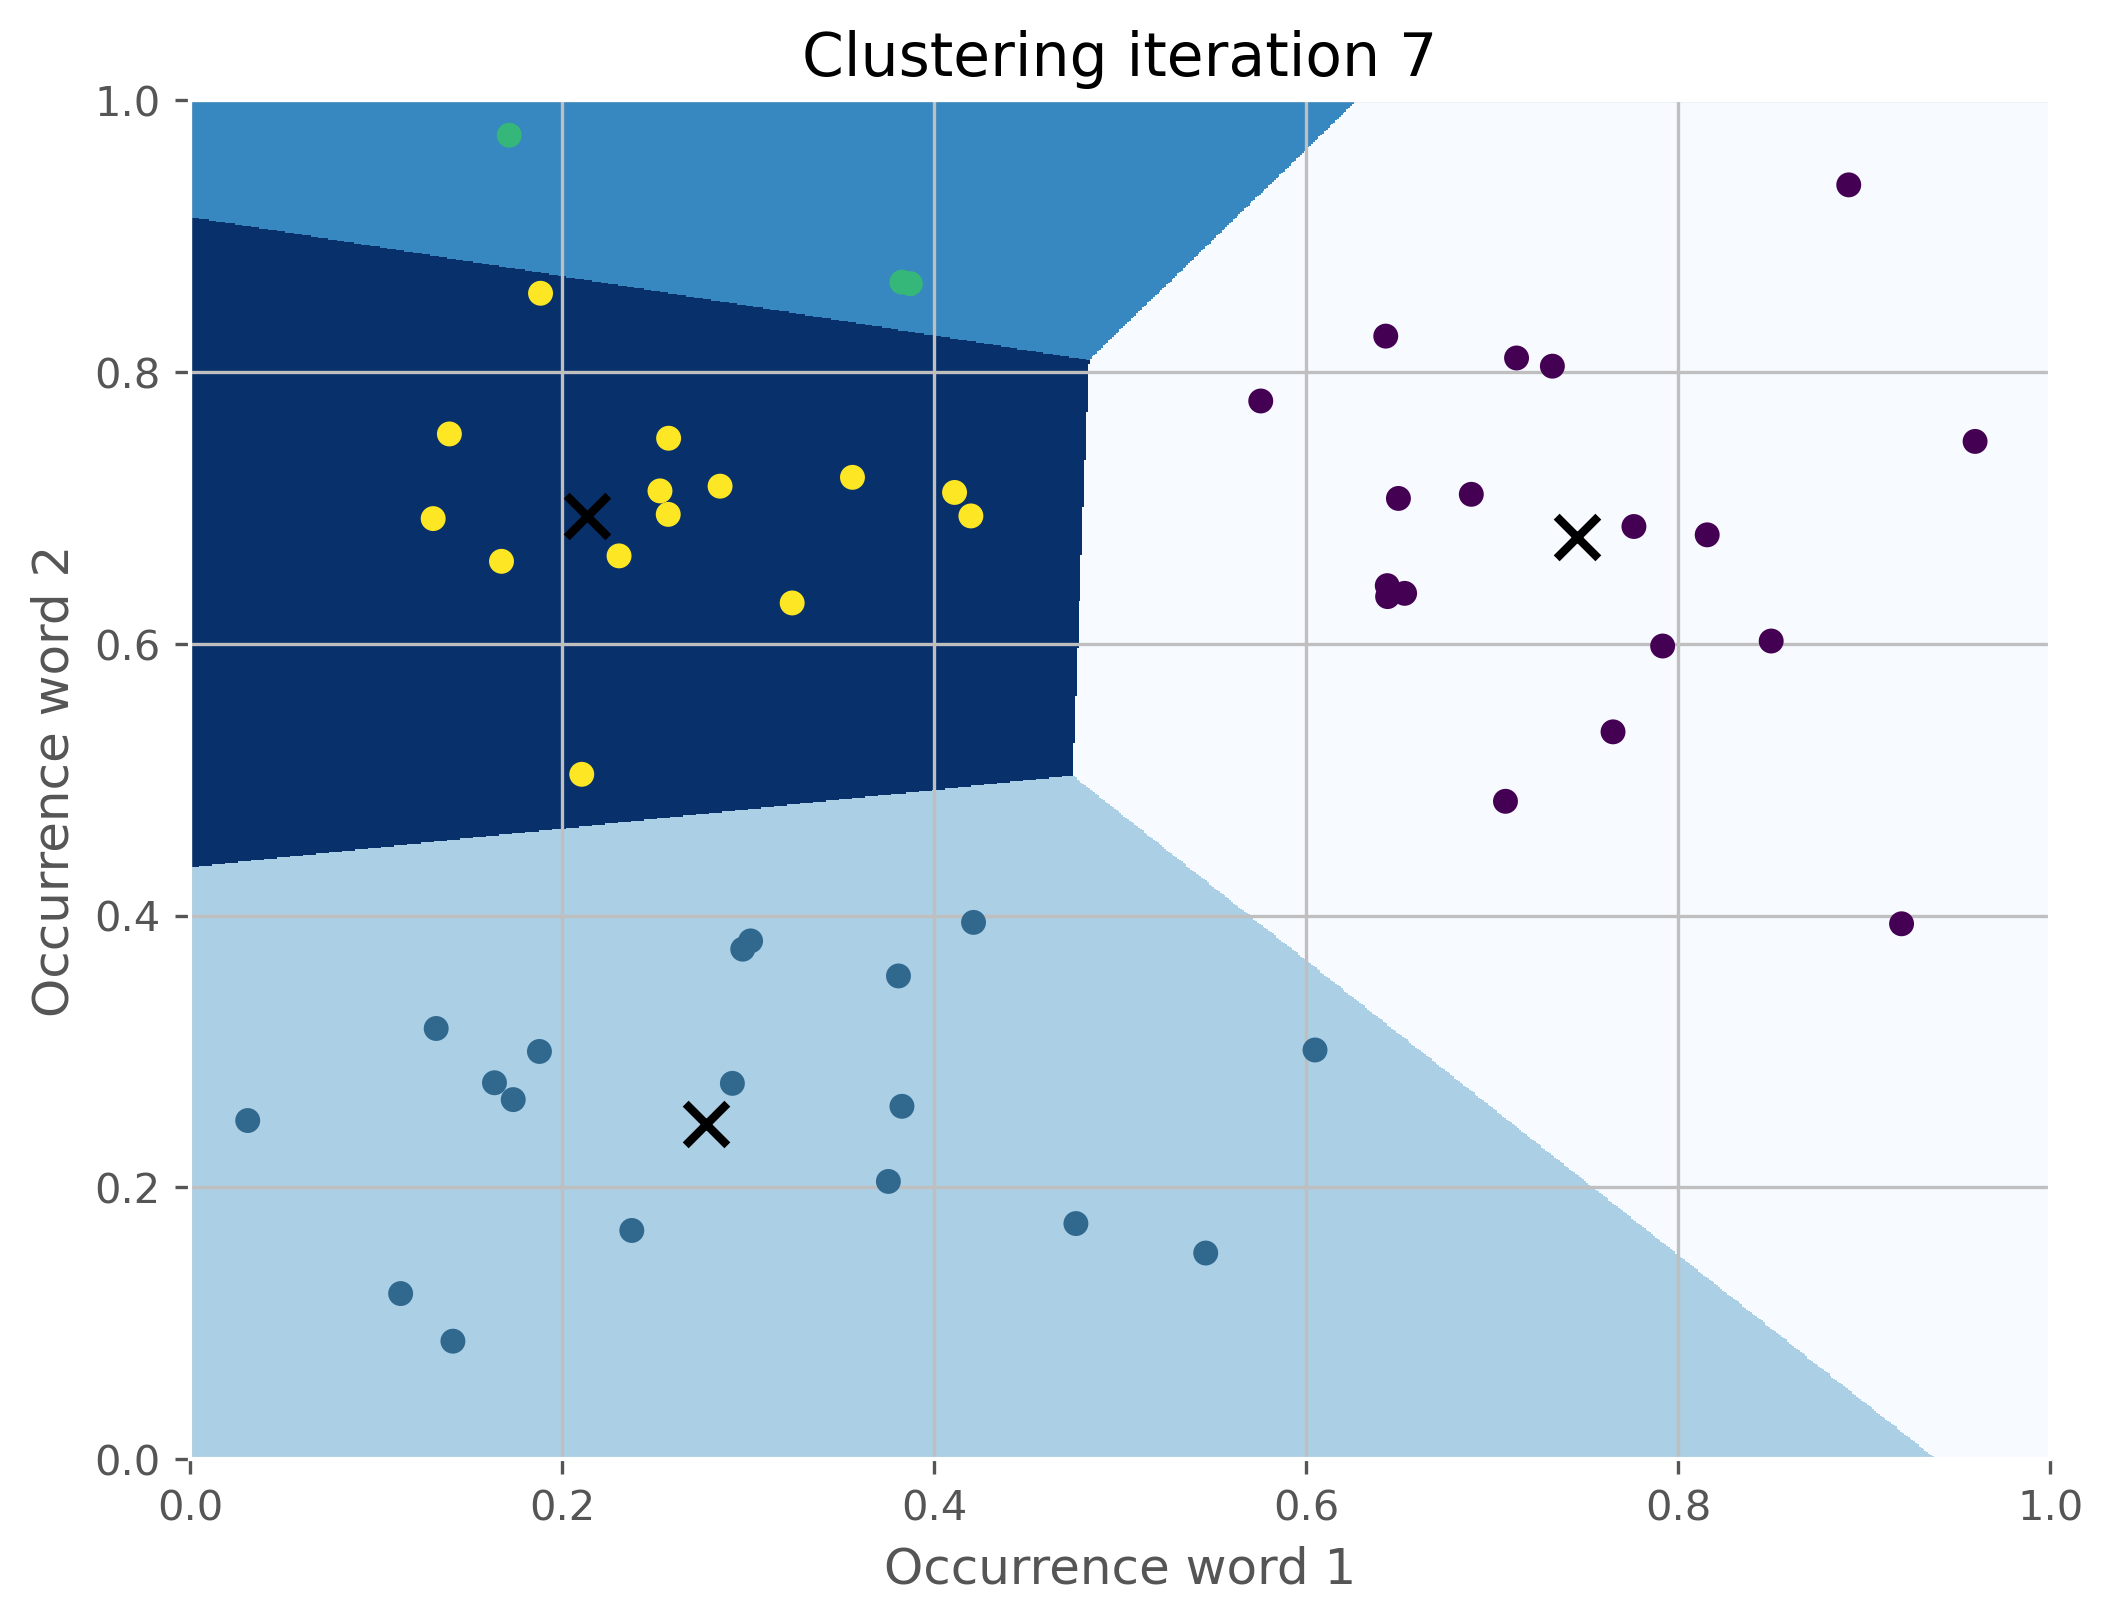

In [68]:
# 7 iterations ####################
km = KMeans(init='random', n_clusters=num_clusters, verbose=1,
            n_init=1, max_iter=7,
            random_state=seed)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 7", km=km)
plt.imshow(Z, interpolation='nearest',
             extent=(mx.min(), mx.max(), my.min(), my.max()),
             cmap=plt.cm.Blues,
             aspect='auto', origin='lower')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
              marker='x', linewidth=2, s=100, color='black')